## Harmonic Preliminary investigation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import statistics
import random
import tqdm
import copy
from matplotlib.pyplot import cm
import pandas as pd


### Propagation Class

In [15]:
class Pandemic_Network():
    
    def __init__(self, network_type: str, nodes: int, pandemicprob: float, mitigation_info = None, NIP = 3, RP = 0, sicknode = 0, SW_connections = 3, SW_randomness = 0.5, SF_k = 1, plots = False, TTR = 15, cum_mit = False):
        '''
        mitigation_info - list: [Proportion that mitigate, Probability of mitigation not working, Start Time, 
                                End Time]. If probability of mitigation not working is a tuple, then implement 
                                directional mitigation. The first value in tuple is for healthy and second is 
                                for infected node.
        sicknodes - number of sick nodes to begin with
        TTR - Time to recover
        RP - Reinfect Probability - probability of being susceptable to reinfection default is 0 i.e. no reinfection
        NIP - Non-Infectious Period
        '''

        if network_type == 'Ring': # default is a ring network
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = 0, seed=None)
        elif network_type == 'Small World':
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = SW_randomness, seed=None)
        elif network_type == 'Scale Free':
            self.g = nx.barabasi_albert_graph(n = nodes, m = SF_k, seed=None, initial_graph=None) # m = Number of edges to attach from a new node to existing nodes
        else:
            self.g = nx.erdos_renyi_graph(n = nodes, p = 0.5, seed=None, directed=False) # if network type not specified, then generate random graph (erdos renyi model)

        #self.pos = nx.circular_layout(self.g)
        self.n = nodes
        self.t = 0
        self.p = pandemicprob
        self.want_plots = plots

        #Mitigations
        if mitigation_info != None:  # if mitigations
            self.mitstart = mitigation_info[2]
            self.mitend = mitigation_info[3]
            self.mitproportion = mitigation_info[0]
            if type(mitigation_info[1]) == tuple:
                self.p_effective_healthy, self.p_effective_infected = mitigation_info[1]
                self.directional = True
            else:
                self.p_effective = mitigation_info[1]
                self.directional = False
        
        self.mitigating = set([])
        self.cum_mit = cum_mit

        
        #Sick nodes
        self.sicknodes = set([random.randint(0, nodes-1) for i in range(sicknode)]) # randomly generate n number of sicknnode
        self.recovered = set([])
        self.TTR = TTR # days to recover, default is 15, customisable dependent on model
        
        #Reinfection
        self.NIP = NIP  # 
        self.RP = RP
        
        # initialise TTR
        initial_TTR_vals = [0 if i not in self.sicknodes else TTR + 1 for i in range(nodes)]
        initial_TTR_dict = {i:initial_TTR_vals[i] for i in range(nodes)}
        nx.set_node_attributes(self.g, initial_TTR_dict, name = 'TTR')
        
        # initialise RP
        initial_NIP_vals = [0 if i not in self.recovered else NIP + 1 for i in range(nodes)]
        initial_NIP_dict = {i:initial_NIP_vals[i] for i in range(nodes)}
        nx.set_node_attributes(self.g, initial_NIP_dict, name = 'NIP')
        # TO Perform reinfection - just introduce a new weight to allow reinfected edges. This weight can be 
        # the probability of infection normally * the probability of reinfection
        
        #Re 
        self.R = dict()
        for node in self.sicknodes:
            self.R[node] = 0 # initialise the infected nodes to having infected 0 other nodes
        self.Rt = []
    
    def plot(self):
        self.pos = nx.circular_layout(self.g)
        node_colors = ["green" if node in self.recovered else 'salmon' if node in self.mitigating and node in self.sicknodes else 'magenta' if node in self.mitigating else "firebrick" if node in self.sicknodes else "skyblue" for node in self.g.nodes()]
        nx.draw_networkx(self.g, pos = self.pos, with_labels=False, node_size=2000/self.n, node_color=node_colors, linewidths=0.5)

        e_no_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p]
        e_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if u in self.mitigating or v in self.mitigating]
        e_sus = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == 0]
        e_rp = [(u,v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p*self.RP]
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_no_mit, width=2, edge_color='red') # un-mitigating
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_mit, width=2, edge_color='orange') # mitigating
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_sus, width=2, edge_color='lime') # susceptible
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_rp, width=2, edge_color='peru') # Reinfected

        
        plt.title("Small Worlds Graph: Nodes = "+ str(len(self.g.nodes()))+ ", Time = " + str(self.t))
        plt.show()
        return
    
    #def sicknode
    def propagate(self, steps: int, populationgrowth = 0, fatalityrate = 0):
        growthrate = populationgrowth/steps
        self.fatalityprob = fatalityrate/self.TTR
        self.newnodes = growthrate*self.n    # number of new nodes to add each step
        nodecounter = self.n
        if self.directional:
            timestamps = []
            infectious_count = []
            recovery_count = []
            uninfected_count = []
            cumulative_case_count = []

            for time in tqdm.tqdm(range(steps)):
                # Adding new nodes
                for i in range(int(self.newnodes)):
                    label = nodecounter
                    self.g.add_node(label)
                    nx.set_node_attributes(self.g, {label:0}, name = 'TTR')
                    nx.set_node_attributes(self.g, {label:0}, name = 'NIP')
                    
                    #Check if new node should be mitigating
                    if random.random() < self.mitproportion:
                        self.mitigating.add(label)
                    
                    #Check if new node has any edges with a sick node
                    neighbours = list(self.g.neighbors(label))
                    for j in neighbours:
                        if j in self.sicknodes:
                            if j in self.mitigating:
                                self.g.add_edge(label, j, weight = self.p*self.p_effective_infected)
                                
                            elif label in self.mitigating:
                                self.g.add_edge(label, j, weight = self.p*self.p_effective_healthy)
                            
                            else:
                                self.g.add_edge(label, j, weight = self.p)
                    nodecounter += 1
                    
                    
                #check sick nodes
                new_sick = 0
                timestamps.append(time)
                # print('Time = ', time)
                # print([self.g.nodes[i]['TTR'] for i in range(len(list(self.g.nodes)))])
                # print('Infectious:', self.sicknodes)
                # print('Recovered:', self.recovered)
                if time == 0:
                    cumulative_case_count.append(len(self.sicknodes))

                    # initialise edge weights
                    edge_list = [(u, v) for (u, v, d) in self.g.edges(data = True)] # all edges
                    for j in edge_list:
                        if (j[0] in self.sicknodes or j[1] in self.sicknodes):
                            self.g.add_edge(j[0], j[1], weight = self.p) 
                        else:
                            self.g.add_edge(j[0], j[1], weight = 0) 


                else: 
                    pass

                if time == self.mitstart:
                    while len(self.mitigating) < int(self.n*self.mitproportion):
                        self.mitigating.add(random.choice(list(self.g.nodes())))

                if time == self.mitend:
                    self.mitigating = []

                infectious_count.append(len(self.sicknodes))
                recovery_count.append(len(self.recovered))
                uninfected_count.append(self.n - len(self.recovered) - len(self.sicknodes))

                currentsick = copy.copy(self.sicknodes) #as new sick nodes may be created and we don't want to loop through the new ones

                for i in list(self.g.nodes):

                    #Checking TTR
                    if self.g.nodes[i]['TTR'] - 1 == 0: # end of infectious period
                        self.sicknodes.remove(i)
                        self.recovered.add(i)
                        nx.set_node_attributes(self.g, {i:self.NIP + 1}, name = 'NIP') # initialise infectious node
                        nx.set_node_attributes(self.g, {i: 0}, name='TTR') # decrement TTR value

                    elif self.g.nodes[i]['TTR'] == 0: # not infectious, no action
                        pass
                    else: # mid infectious period
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value    

                    #Checking NIP
                    if self.g.nodes[i]['NIP'] -1 == 0:
                        self.recovered.remove(i)
                        neighbours = list(self.g.neighbors(i))
                        for n in neighbours:
                            self.g.add_edge(i, n, weight = self.RP*self.p)  # after infection, new weights should be probability of infection * probability of reinfection

                        #if i in self.mitigating:
                        #    self.mitigating.remove(i)
                        #else:
                        #    pass
                        nx.set_node_attributes(self.g, {i: 0}, name='NIP') # decrement TTR value

                    elif self.g.nodes[i]['NIP'] == 0: # not non-infectious period, no action
                        pass
                    else:
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['NIP'] - 1}, name='NIP') # decrement TTR value    


                for node in currentsick:
                    # Check if node should be removed i.e. it dies
                    if random.random() < self.fatalityprob:  
                        self.g.remove_node(node) # remove node from graph
                        if node in self.sicknodes: # if node hasn't already recovered
                            self.sicknodes.remove(node) # remove node from sicknodes
                        continue # move on to new node
                    
                    neighbours = list(self.g.neighbors(node))
                    #try to propagate sickness
                    for neighbour in neighbours:
                        if neighbour in self.sicknodes or neighbour in self.recovered: # do not infect again if already sick.
                            pass
                        elif node in self.mitigating:
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']*self.p_effective_infected: # infected node mitigating
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                        self.g.add_edge(i, neighbour, weight = self.p)

                        elif neighbour in self.mitigating: # node did not adopt mitigation measure 
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']*self.p_effective_healthy: # healthy node mitigating
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                        self.g.add_edge(i, neighbour, weight = self.p)
                        else: # node not infected
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']:  # no node mitigating
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                        self.g.add_edge(i, neighbour, weight = self.p)

                self.Rt.append((new_sick/len(currentsick))*5) # Can just calculate Rt using this as it is just ratio of new people infected with currently infected nodes
                cumulative_case_count.append(cumulative_case_count[-1] + new_sick)
                self.t += 1 #timestep increase by 1

                if self.want_plots: 
                    self.plot()


                #If no more sick nodes than we can finish propagation
                if len(self.sicknodes) == 0:
                    break
                    
        else: # if not directed mitigation probability of effectiveness
            timestamps = []
            infectious_count = []
            recovery_count = []
            uninfected_count = []
            cumulative_case_count = []
            # Adding new nodes
            for i in range(int(self.newnodes)):
                label = nodecounter
                self.g.add_node(label)
                nx.set_node_attributes(self.g, {label:0}, name = 'TTR')
                nx.set_node_attributes(self.g, {label:0}, name = 'NIP')
                
                #Check if new node should be mitigating
                if random.random() < self.mitproportion:
                    self.mitigating.add(label)
                    
                #Check if new node has any edges with a sick node
                neighbours = list(self.g.neighbors(label))
                for j in neighbours:
                    if j in self.sicknodes:
                        if j in self.mitigating or label in self.mitigating:
                            self.g.add_edge(label, j, weight = self.p*self.p_effective)
                                
                        else:
                            self.g.add_edge(label, j, weight = self.p)
                    nodecounter += 1
                    
            for time in tqdm.tqdm(range(steps)):
                #check sick nodes
                new_sick = 0
                timestamps.append(time)
                # print('Time = ', time)
                # print([self.g.nodes[i]['TTR'] for i in range(len(list(self.g.nodes)))])
                # print('Infectious:', self.sicknodes)
                # print('Recovered:', self.recovered)
                if time == 0:
                    cumulative_case_count.append(len(self.sicknodes))

                    # initialise edge weights
                    edge_list = [(u, v) for (u, v, d) in self.g.edges(data = True)] # all edges
                    for j in edge_list:
                        if (j[0] in self.sicknodes or j[1] in self.sicknodes):
                            self.g.add_edge(j[0], j[1], weight = self.p) 
                        else:
                            self.g.add_edge(j[0], j[1], weight = 0) 

                    # self.plot()

                else: 
                    pass

                if time == self.mitstart:
                    while len(self.mitigating) < int(self.n*self.mitproportion):
                        self.mitigating.add(random.choice(list(self.g.nodes())))

                if time == self.mitend:
                    self.mitigating = []

                infectious_count.append(len(self.sicknodes))
                recovery_count.append(len(self.recovered))
                uninfected_count.append(self.n - len(self.recovered) - len(self.sicknodes))

                currentsick = copy.copy(self.sicknodes) #as new sick nodes may be created and we don't want to loop through the new ones

                for i in range(len(list(self.g.nodes))):

                    #Checking TTR
                    if self.g.nodes[i]['TTR'] - 1 == 0: # end of infectious period
                        self.sicknodes.remove(i)
                        self.recovered.add(i)
                        nx.set_node_attributes(self.g, {i:self.NIP + 1}, name = 'NIP') # initialise infectious node
                        nx.set_node_attributes(self.g, {i: 0}, name='TTR') # decrement TTR value

                    elif self.g.nodes[i]['TTR'] == 0: # not infectious, no action
                        pass
                    else: # mid infectious period
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value    

                    #Checking NIP
                    if self.g.nodes[i]['NIP'] -1 == 0:
                        self.recovered.remove(i)
                        neighbours = list(self.g.neighbors(i))
                        for n in neighbours:
                            self.g.add_edge(i, n, weight = self.RP*self.p)  # after infection, new weights should be probability of infection * probability of reinfection

                        #if i in self.mitigating:
                        #    self.mitigating.remove(i)
                        #else:
                        #    pass
                        nx.set_node_attributes(self.g, {i: 0}, name='NIP') # decrement TTR value

                    elif self.g.nodes[i]['NIP'] == 0: # not non-infectious period, no action
                        pass
                    else:
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['NIP'] - 1}, name='NIP') # decrement TTR value    


                for node in currentsick:
                    # Check if node should be removed i.e. it dies
                    if random.random() < self.fatalityprob:  
                        self.g.remove_node(node) # remove node from graph
                        self.sicknodes.remove(node) # remove node from sicknodes
                        continue # move on to new node
                    
                    neighbours = list(self.g.neighbors(node))

                    #try to propagate sickness
                    for neighbour in neighbours:

                        if neighbour in self.sicknodes or neighbour in self.recovered: # do not infect again if already sick.
                            pass
                        elif node in self.mitigating or neighbour in self.mitigating:
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']*self.p_effective: # new node infected
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                    self.g.add_edge(i, neighbour, weight = self.p)

                        else: # node not infected
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']: # new node infected
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                    self.g.add_edge(i, neighbour, weight = self.p)

                self.Rt.append((new_sick/len(currentsick))*self.TTR) # Can just calculate Rt using this as it is just ratio of new people infected with currently infected nodes
                cumulative_case_count.append(cumulative_case_count[-1] + new_sick)
                self.t += 1 #timestep increase by 1

                if self.want_plots: 
                    self.plot()


                #If no more sick nodes than we can finish propagation
                if len(self.sicknodes) == 0:
                    break
                
        # self.plot()             
        return timestamps, infectious_count, recovery_count, uninfected_count, cumulative_case_count[:-1], self.Rt
    


Investigating whether plots can exhibit different types of damping

0.02 7  Repeat Number:  0


 14%|█████▋                                    | 68/500 [00:04<00:27, 15.75it/s]


0.02 7  Repeat Number:  1


 15%|██████▎                                   | 75/500 [00:04<00:25, 16.61it/s]


0.02 7  Repeat Number:  2


  5%|██                                        | 24/500 [00:01<00:32, 14.74it/s]


0.02 7  Repeat Number:  3


  7%|███                                       | 37/500 [00:02<00:29, 15.97it/s]


0.02 7  Repeat Number:  4


 29%|███████████▋                             | 143/500 [00:08<00:20, 17.03it/s]


0.02 7  Repeat Number:  5


  5%|██▎                                       | 27/500 [00:01<00:30, 15.43it/s]


0.02 7  Repeat Number:  6


  2%|▊                                         | 10/500 [00:00<00:41, 11.80it/s]


0.02 7  Repeat Number:  7


 74%|██████████████████████████████▎          | 370/500 [00:21<00:07, 17.20it/s]


0.02 7  Repeat Number:  8


  2%|▊                                         | 10/500 [00:00<00:40, 12.02it/s]


0.02 7  Repeat Number:  9


 23%|█████████▌                               | 117/500 [00:06<00:22, 17.18it/s]


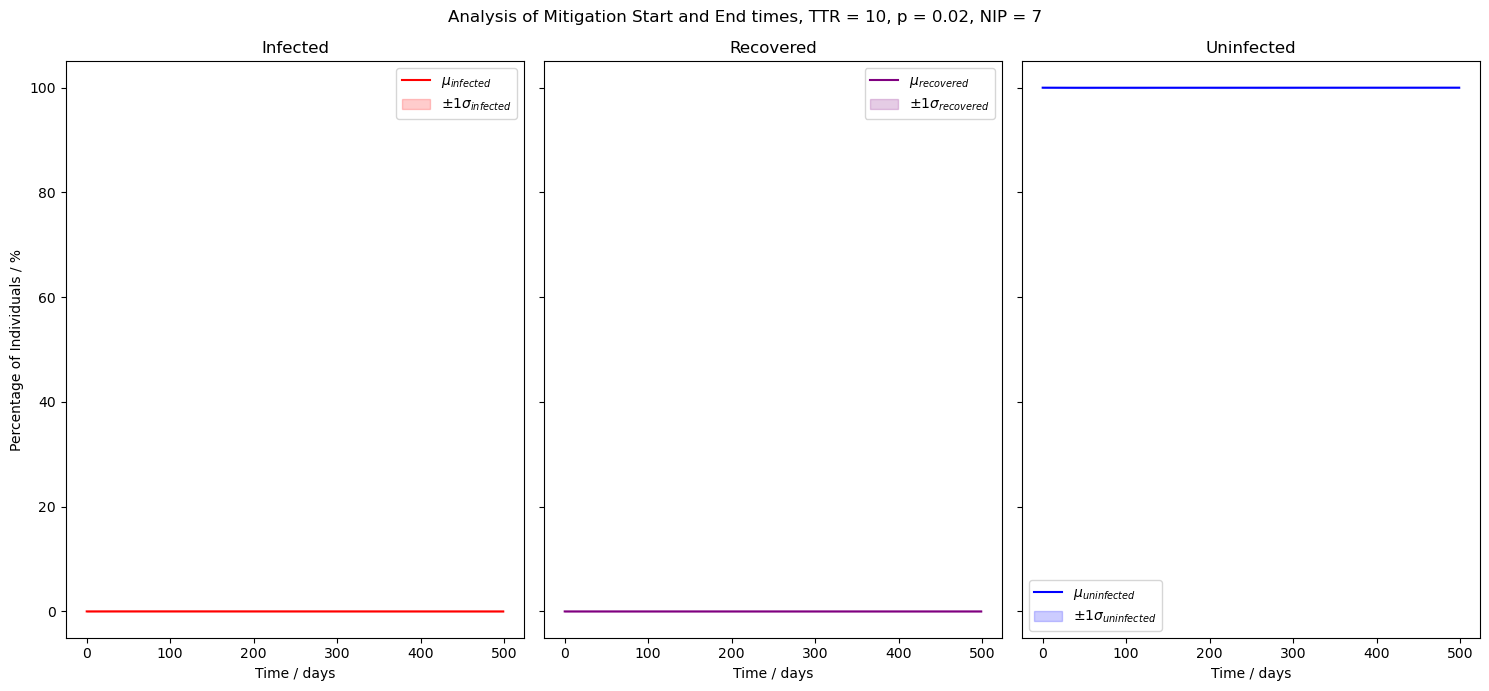

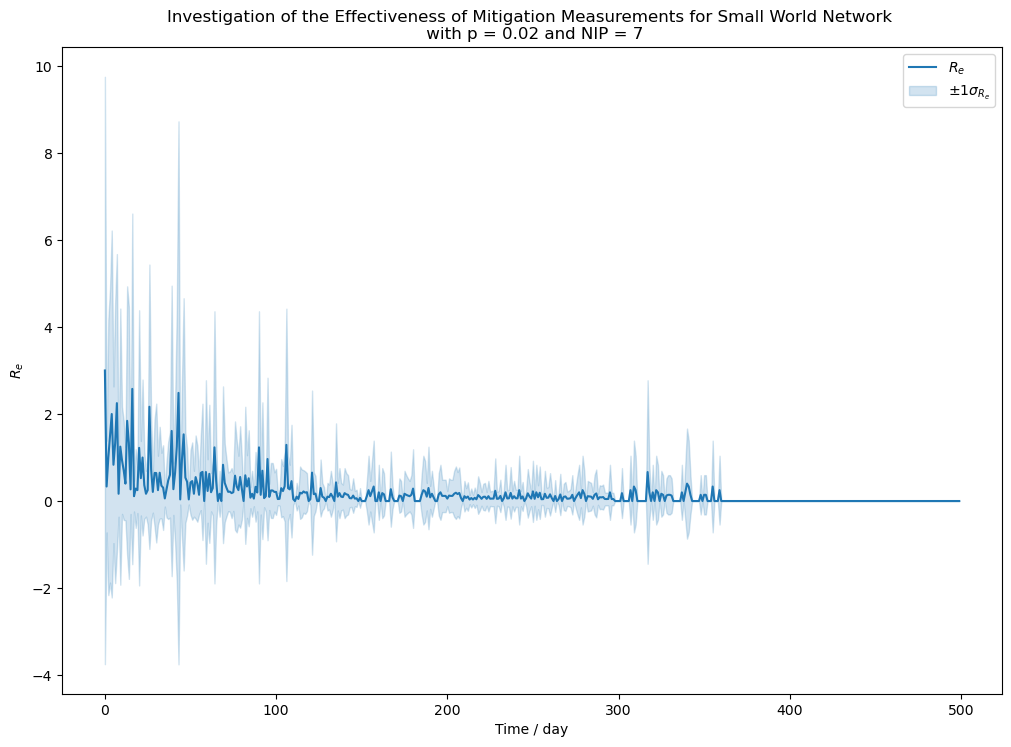

0.05 7  Repeat Number:  0


100%|█████████████████████████████████████████| 500/500 [01:17<00:00,  6.45it/s]


0.05 7  Repeat Number:  1


100%|█████████████████████████████████████████| 500/500 [01:22<00:00,  6.04it/s]


0.05 7  Repeat Number:  2


100%|█████████████████████████████████████████| 500/500 [01:16<00:00,  6.54it/s]


0.05 7  Repeat Number:  3


100%|█████████████████████████████████████████| 500/500 [01:16<00:00,  6.55it/s]


0.05 7  Repeat Number:  4


100%|█████████████████████████████████████████| 500/500 [01:16<00:00,  6.52it/s]


0.05 7  Repeat Number:  5


100%|█████████████████████████████████████████| 500/500 [01:15<00:00,  6.59it/s]


0.05 7  Repeat Number:  6


100%|█████████████████████████████████████████| 500/500 [01:16<00:00,  6.51it/s]


0.05 7  Repeat Number:  7


100%|█████████████████████████████████████████| 500/500 [01:14<00:00,  6.68it/s]


0.05 7  Repeat Number:  8


100%|█████████████████████████████████████████| 500/500 [01:15<00:00,  6.61it/s]


0.05 7  Repeat Number:  9


100%|█████████████████████████████████████████| 500/500 [01:14<00:00,  6.72it/s]


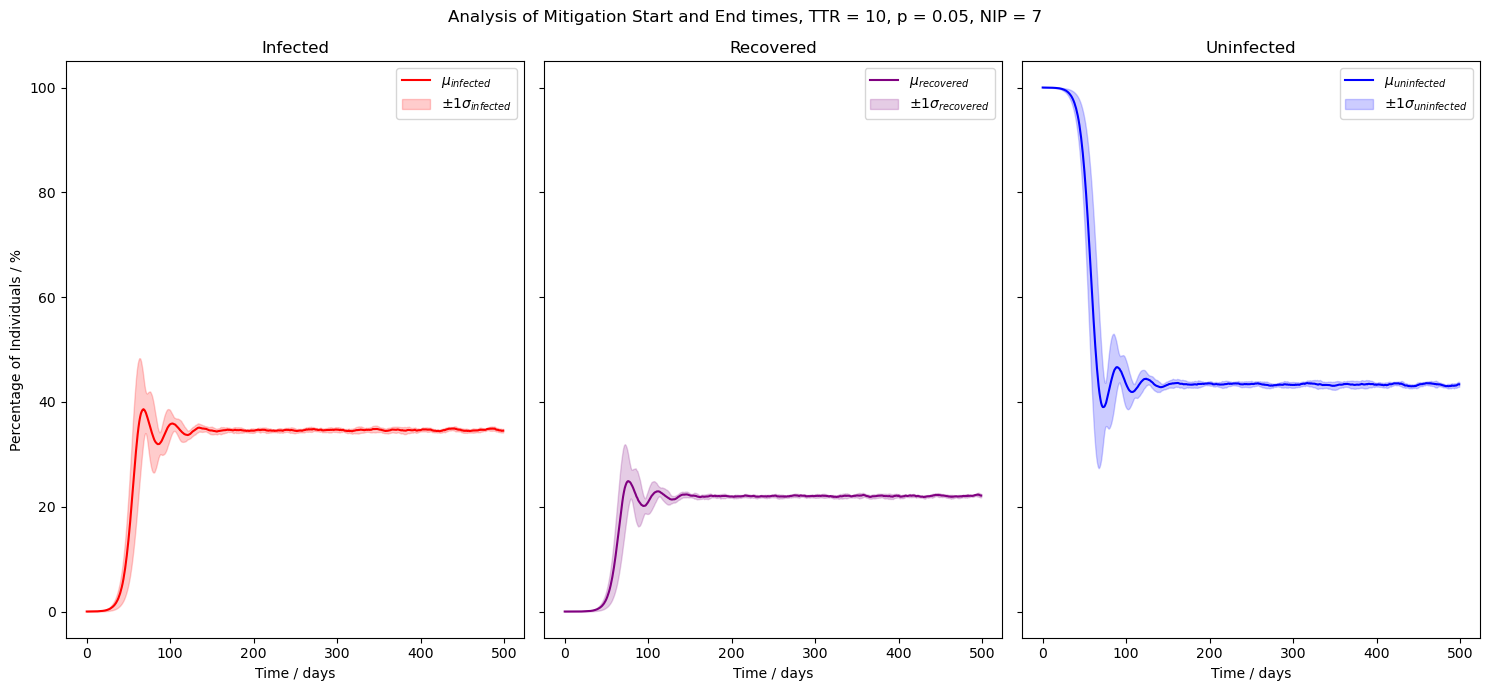

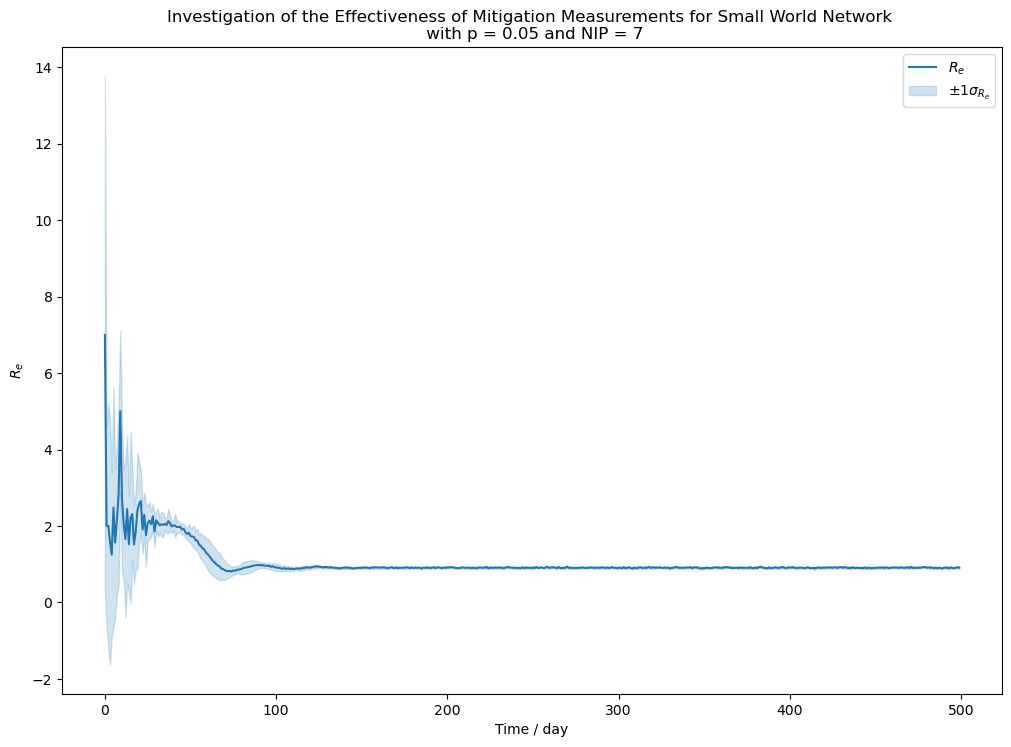

0.07 7  Repeat Number:  0


100%|█████████████████████████████████████████| 500/500 [01:23<00:00,  6.02it/s]


0.07 7  Repeat Number:  1


100%|█████████████████████████████████████████| 500/500 [01:24<00:00,  5.94it/s]


0.07 7  Repeat Number:  2


100%|█████████████████████████████████████████| 500/500 [01:29<00:00,  5.58it/s]


0.07 7  Repeat Number:  3


100%|█████████████████████████████████████████| 500/500 [01:21<00:00,  6.10it/s]


0.07 7  Repeat Number:  4


100%|█████████████████████████████████████████| 500/500 [01:22<00:00,  6.05it/s]


0.07 7  Repeat Number:  5


100%|█████████████████████████████████████████| 500/500 [01:21<00:00,  6.12it/s]


0.07 7  Repeat Number:  6


100%|█████████████████████████████████████████| 500/500 [01:22<00:00,  6.08it/s]


0.07 7  Repeat Number:  7


100%|█████████████████████████████████████████| 500/500 [01:19<00:00,  6.26it/s]


0.07 7  Repeat Number:  8


100%|█████████████████████████████████████████| 500/500 [01:23<00:00,  5.99it/s]


0.07 7  Repeat Number:  9


100%|█████████████████████████████████████████| 500/500 [01:23<00:00,  6.01it/s]


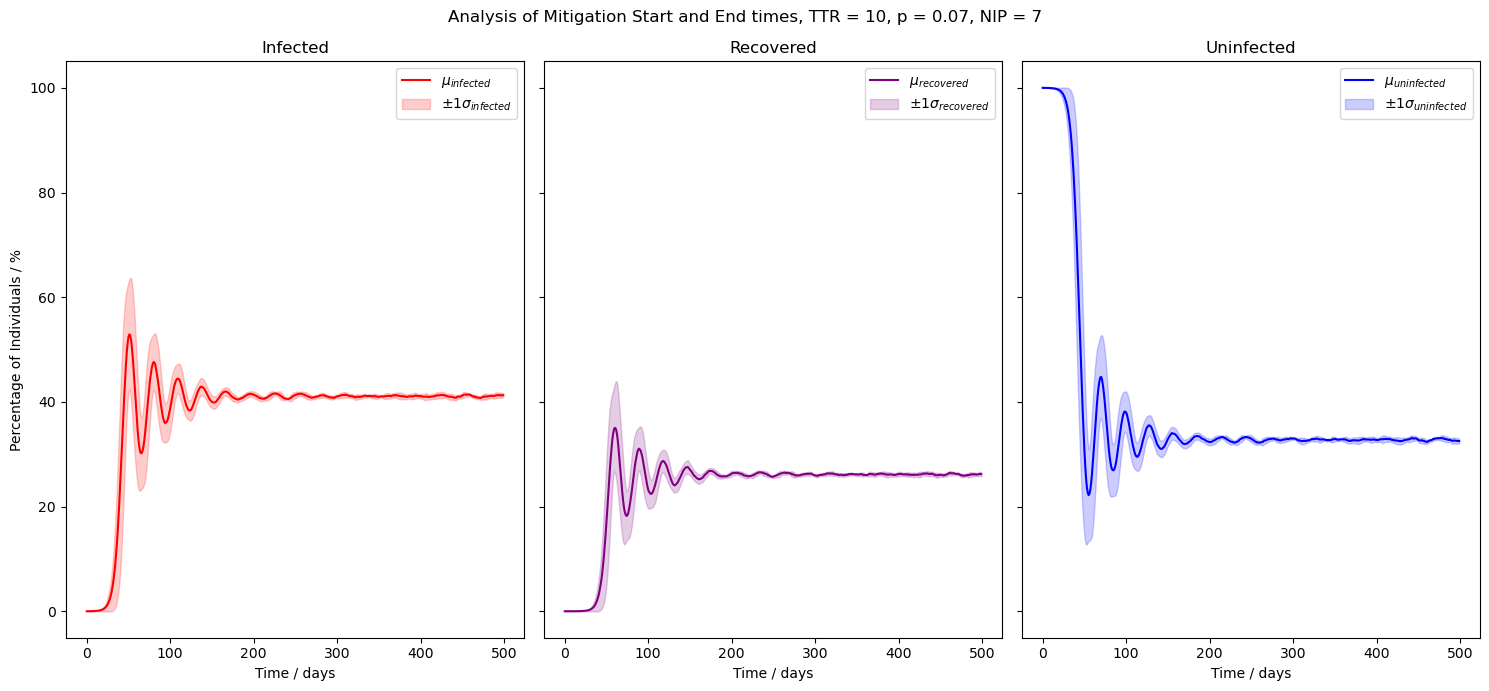

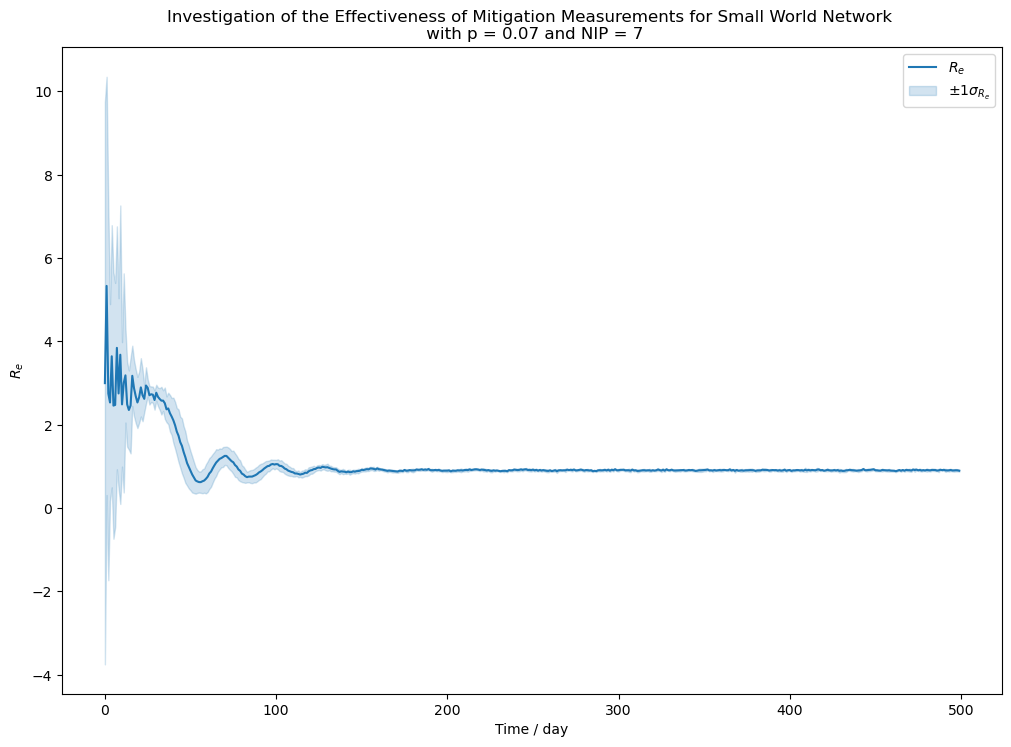

0.1 7  Repeat Number:  0


100%|█████████████████████████████████████████| 500/500 [01:26<00:00,  5.81it/s]


0.1 7  Repeat Number:  1


100%|█████████████████████████████████████████| 500/500 [01:25<00:00,  5.83it/s]


0.1 7  Repeat Number:  2


100%|█████████████████████████████████████████| 500/500 [01:25<00:00,  5.82it/s]


0.1 7  Repeat Number:  3


100%|█████████████████████████████████████████| 500/500 [01:25<00:00,  5.85it/s]


0.1 7  Repeat Number:  4


100%|█████████████████████████████████████████| 500/500 [01:25<00:00,  5.84it/s]


0.1 7  Repeat Number:  5


100%|█████████████████████████████████████████| 500/500 [01:25<00:00,  5.83it/s]


0.1 7  Repeat Number:  6


100%|█████████████████████████████████████████| 500/500 [01:25<00:00,  5.82it/s]


0.1 7  Repeat Number:  7


100%|█████████████████████████████████████████| 500/500 [01:25<00:00,  5.87it/s]


0.1 7  Repeat Number:  8


100%|█████████████████████████████████████████| 500/500 [01:25<00:00,  5.83it/s]


0.1 7  Repeat Number:  9


100%|█████████████████████████████████████████| 500/500 [01:25<00:00,  5.87it/s]


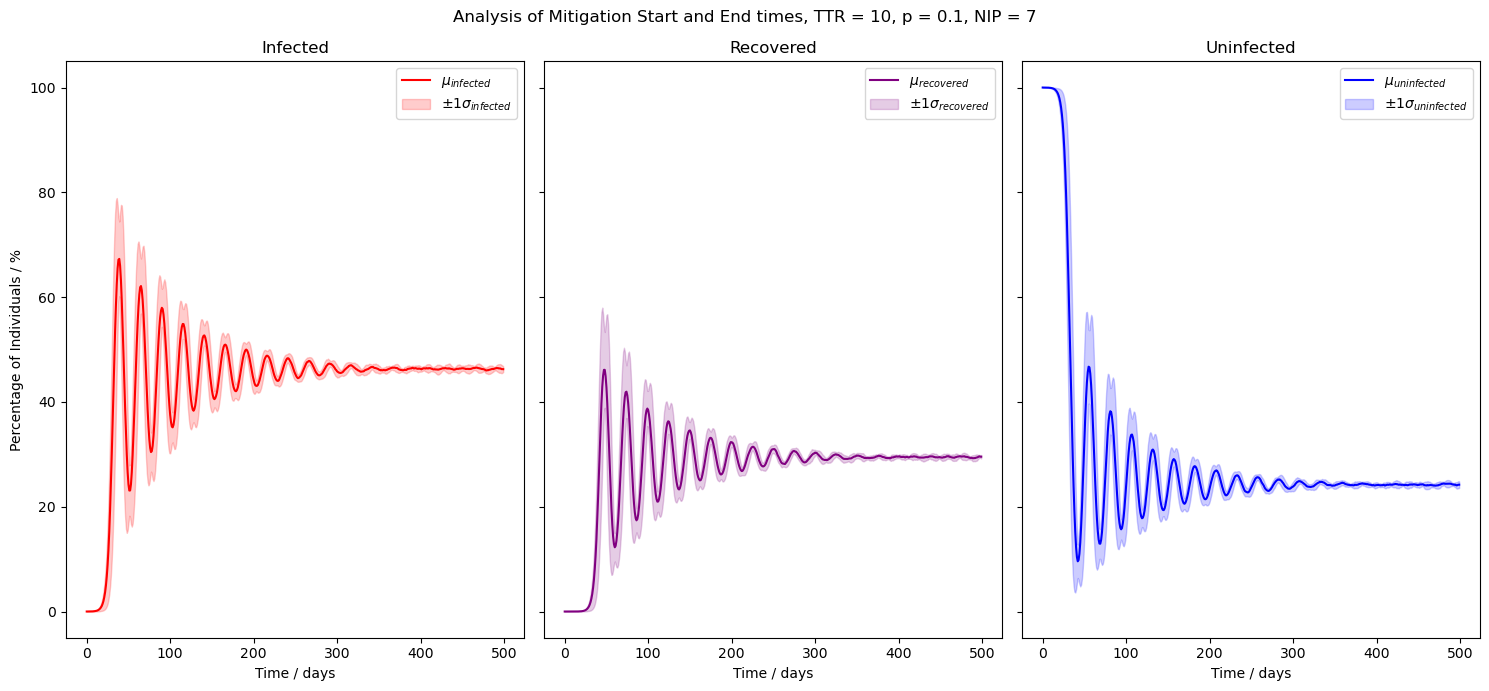

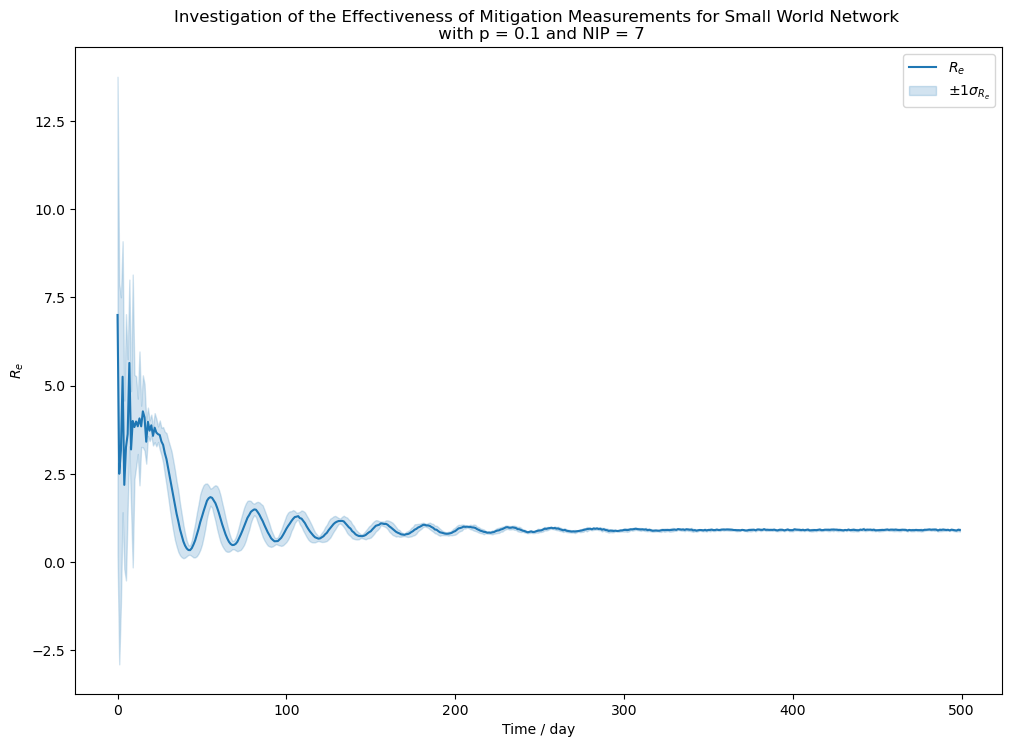

0.15 7  Repeat Number:  0


100%|█████████████████████████████████████████| 500/500 [01:27<00:00,  5.69it/s]


0.15 7  Repeat Number:  1


100%|█████████████████████████████████████████| 500/500 [01:27<00:00,  5.74it/s]


0.15 7  Repeat Number:  2


100%|█████████████████████████████████████████| 500/500 [01:27<00:00,  5.72it/s]


0.15 7  Repeat Number:  3


100%|█████████████████████████████████████████| 500/500 [01:27<00:00,  5.70it/s]


0.15 7  Repeat Number:  4


100%|█████████████████████████████████████████| 500/500 [01:27<00:00,  5.72it/s]


0.15 7  Repeat Number:  5


100%|█████████████████████████████████████████| 500/500 [01:27<00:00,  5.74it/s]


0.15 7  Repeat Number:  6


100%|█████████████████████████████████████████| 500/500 [01:28<00:00,  5.65it/s]


0.15 7  Repeat Number:  7


100%|█████████████████████████████████████████| 500/500 [01:27<00:00,  5.74it/s]


0.15 7  Repeat Number:  8


100%|█████████████████████████████████████████| 500/500 [01:28<00:00,  5.66it/s]


0.15 7  Repeat Number:  9


100%|█████████████████████████████████████████| 500/500 [01:27<00:00,  5.72it/s]


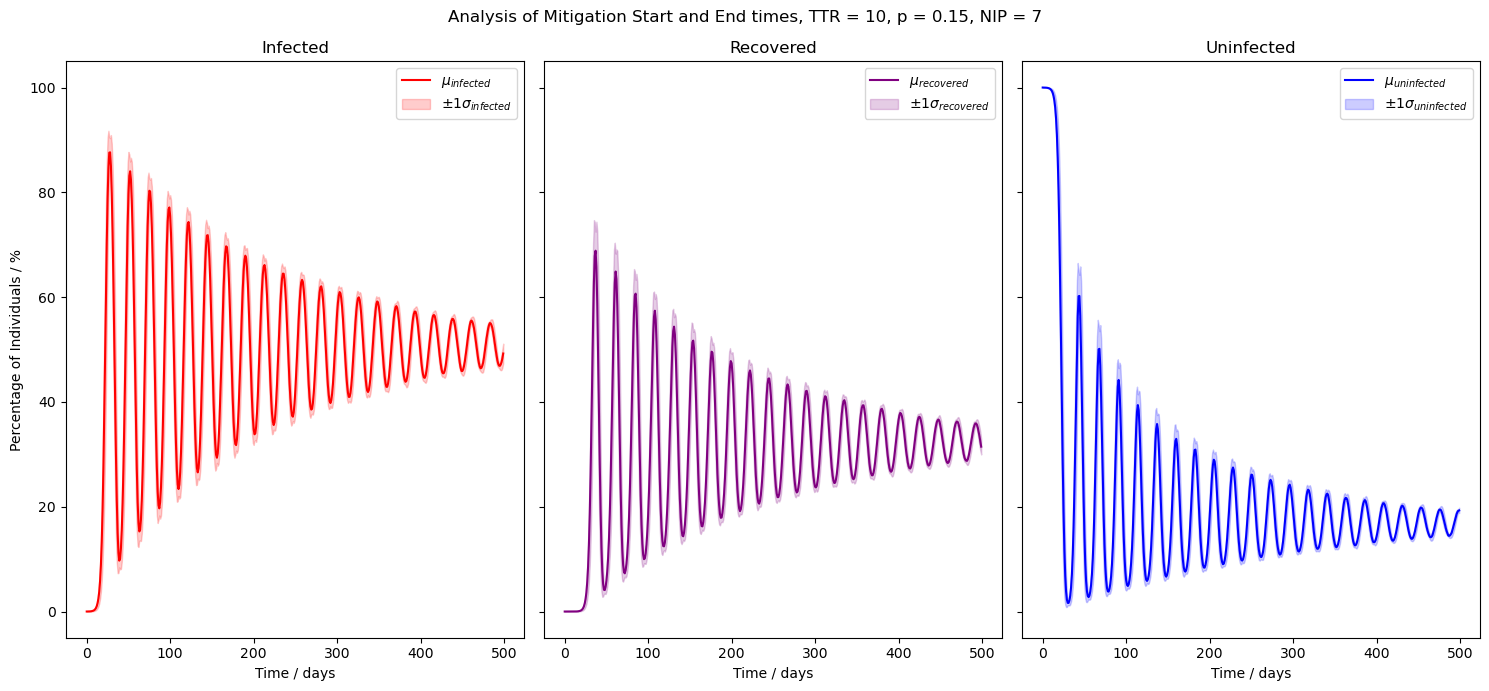

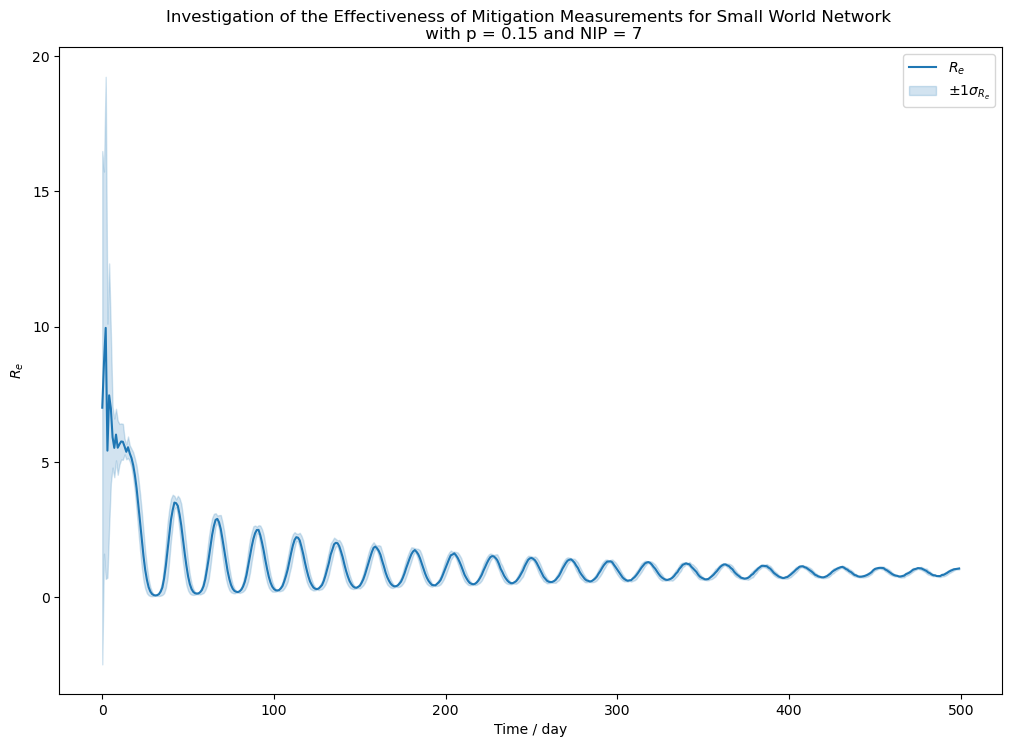

0.2 7  Repeat Number:  0


100%|█████████████████████████████████████████| 500/500 [01:26<00:00,  5.76it/s]


0.2 7  Repeat Number:  1


100%|█████████████████████████████████████████| 500/500 [01:26<00:00,  5.81it/s]


0.2 7  Repeat Number:  2


100%|█████████████████████████████████████████| 500/500 [01:26<00:00,  5.78it/s]


0.2 7  Repeat Number:  3


100%|█████████████████████████████████████████| 500/500 [01:26<00:00,  5.76it/s]


0.2 7  Repeat Number:  4


100%|█████████████████████████████████████████| 500/500 [01:26<00:00,  5.77it/s]


0.2 7  Repeat Number:  5


100%|█████████████████████████████████████████| 500/500 [01:27<00:00,  5.74it/s]


0.2 7  Repeat Number:  6


100%|█████████████████████████████████████████| 500/500 [01:26<00:00,  5.79it/s]


0.2 7  Repeat Number:  7


100%|█████████████████████████████████████████| 500/500 [01:26<00:00,  5.77it/s]


0.2 7  Repeat Number:  8


100%|█████████████████████████████████████████| 500/500 [01:26<00:00,  5.76it/s]


0.2 7  Repeat Number:  9


100%|█████████████████████████████████████████| 500/500 [01:27<00:00,  5.74it/s]


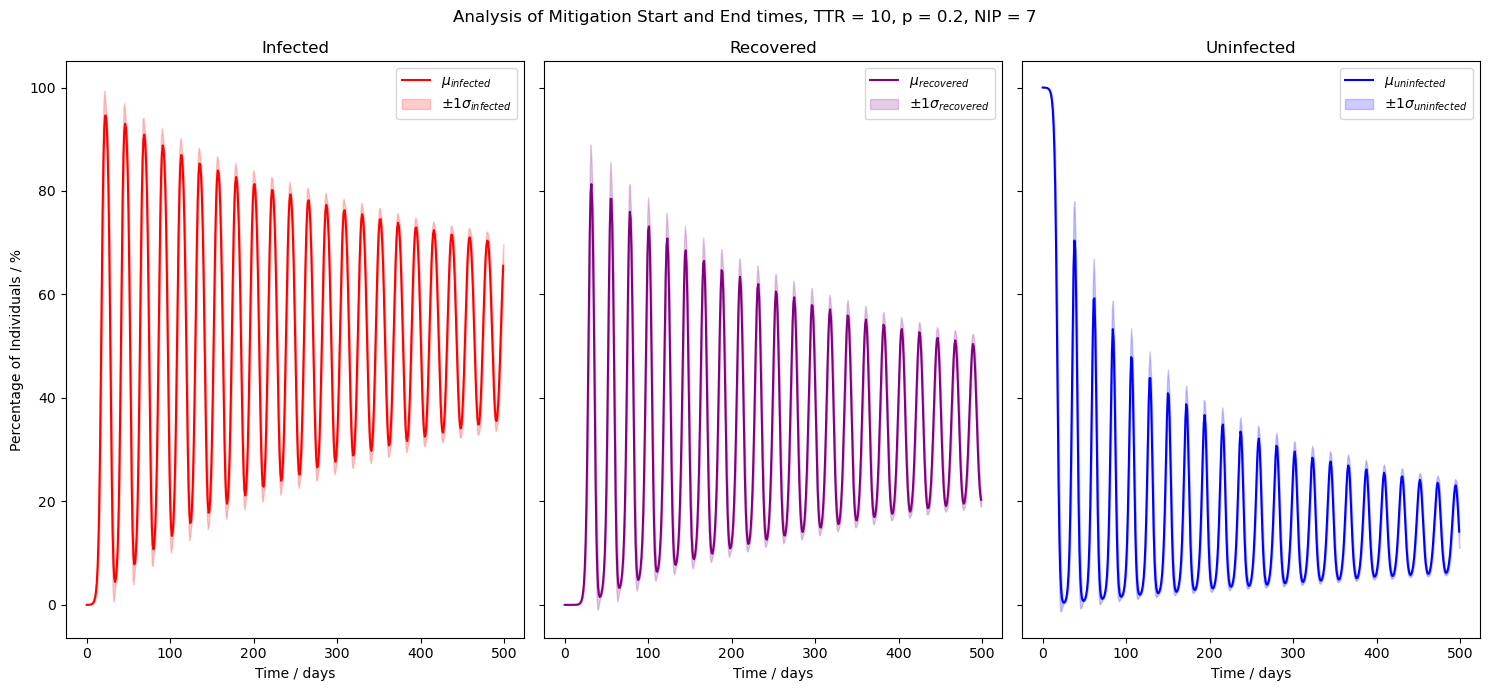

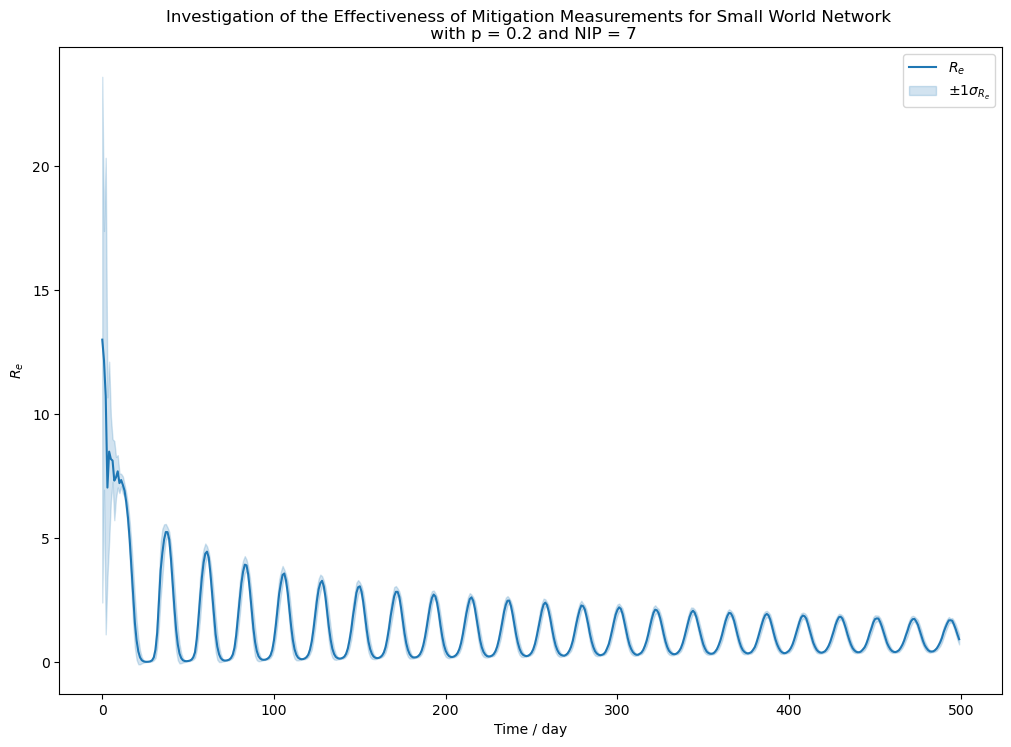

0.25 7  Repeat Number:  0


100%|█████████████████████████████████████████| 500/500 [01:25<00:00,  5.84it/s]


0.25 7  Repeat Number:  1


100%|█████████████████████████████████████████| 500/500 [01:26<00:00,  5.80it/s]


0.25 7  Repeat Number:  2


100%|█████████████████████████████████████████| 500/500 [01:25<00:00,  5.86it/s]


0.25 7  Repeat Number:  3


100%|█████████████████████████████████████████| 500/500 [01:25<00:00,  5.86it/s]


0.25 7  Repeat Number:  4


100%|█████████████████████████████████████████| 500/500 [01:30<00:00,  5.55it/s]


0.25 7  Repeat Number:  5


100%|█████████████████████████████████████████| 500/500 [01:26<00:00,  5.80it/s]


0.25 7  Repeat Number:  6


100%|█████████████████████████████████████████| 500/500 [01:25<00:00,  5.82it/s]


0.25 7  Repeat Number:  7


100%|█████████████████████████████████████████| 500/500 [01:25<00:00,  5.86it/s]


0.25 7  Repeat Number:  8


100%|█████████████████████████████████████████| 500/500 [01:26<00:00,  5.78it/s]


0.25 7  Repeat Number:  9


100%|█████████████████████████████████████████| 500/500 [01:25<00:00,  5.84it/s]


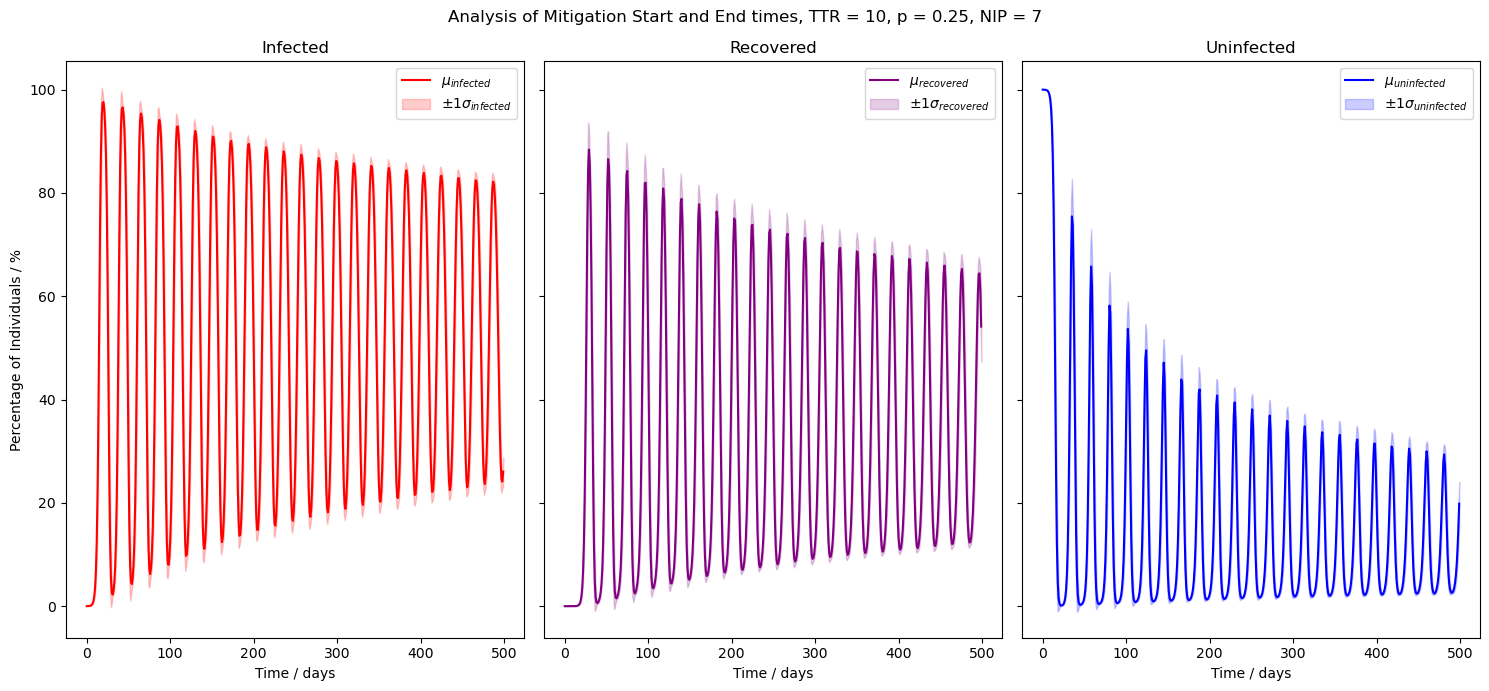

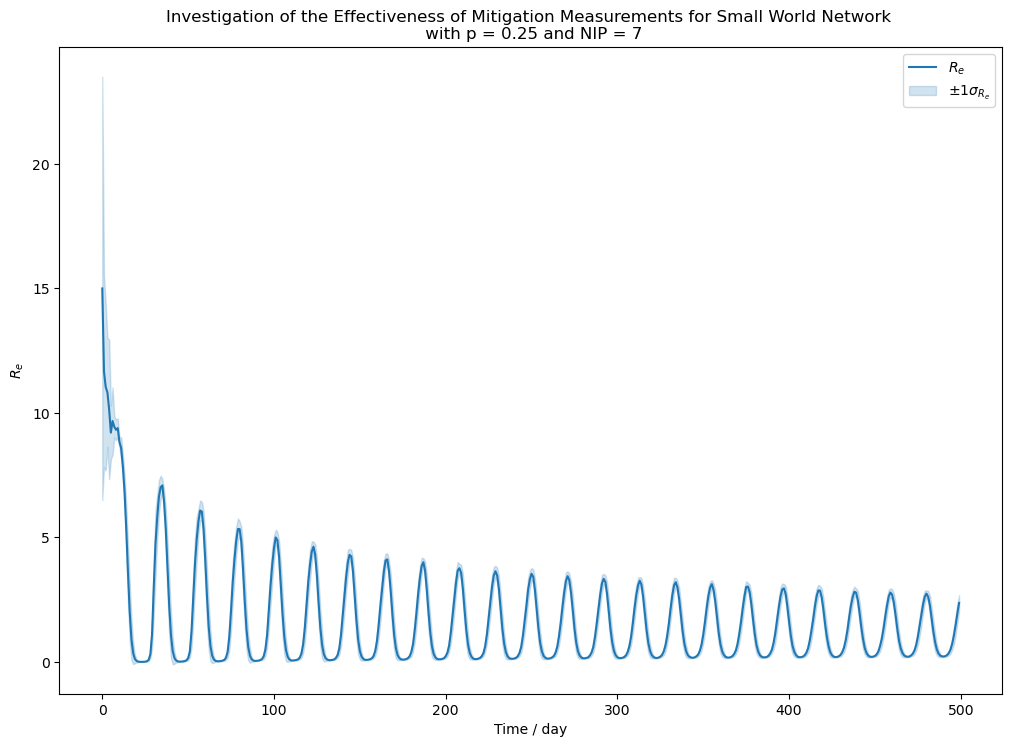

0.3 7  Repeat Number:  0


100%|█████████████████████████████████████████| 500/500 [01:25<00:00,  5.86it/s]


0.3 7  Repeat Number:  1


100%|█████████████████████████████████████████| 500/500 [07:24<00:00,  1.12it/s]


0.3 7  Repeat Number:  2


100%|█████████████████████████████████████████| 500/500 [02:00<00:00,  4.15it/s]


0.3 7  Repeat Number:  3


100%|█████████████████████████████████████████| 500/500 [10:39<00:00,  1.28s/it]


0.3 7  Repeat Number:  4


100%|█████████████████████████████████████████| 500/500 [10:20<00:00,  1.24s/it]


0.3 7  Repeat Number:  5


100%|█████████████████████████████████████████| 500/500 [06:59<00:00,  1.19it/s]


0.3 7  Repeat Number:  6


100%|█████████████████████████████████████████| 500/500 [01:25<00:00,  5.84it/s]


0.3 7  Repeat Number:  7


100%|█████████████████████████████████████████| 500/500 [01:24<00:00,  5.94it/s]


0.3 7  Repeat Number:  8


100%|█████████████████████████████████████████| 500/500 [01:24<00:00,  5.90it/s]


0.3 7  Repeat Number:  9


100%|█████████████████████████████████████████| 500/500 [01:25<00:00,  5.85it/s]


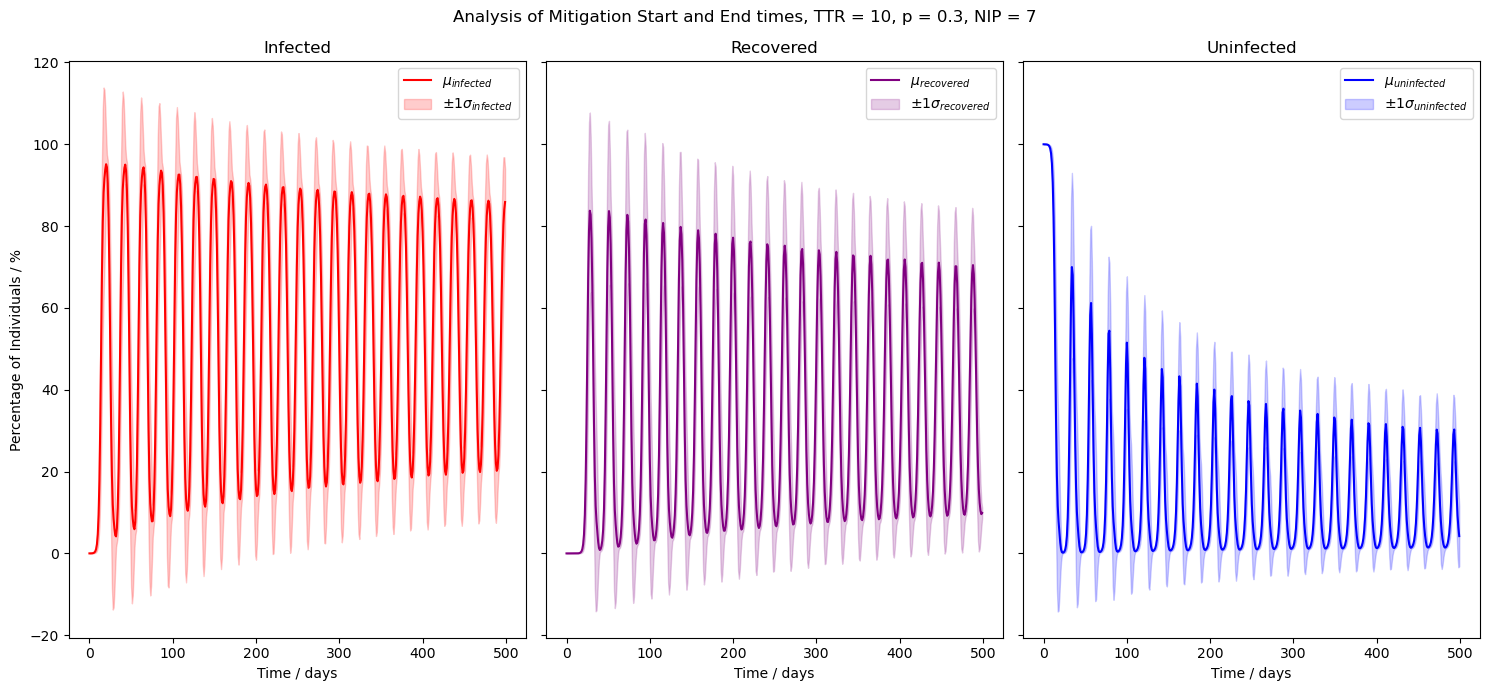

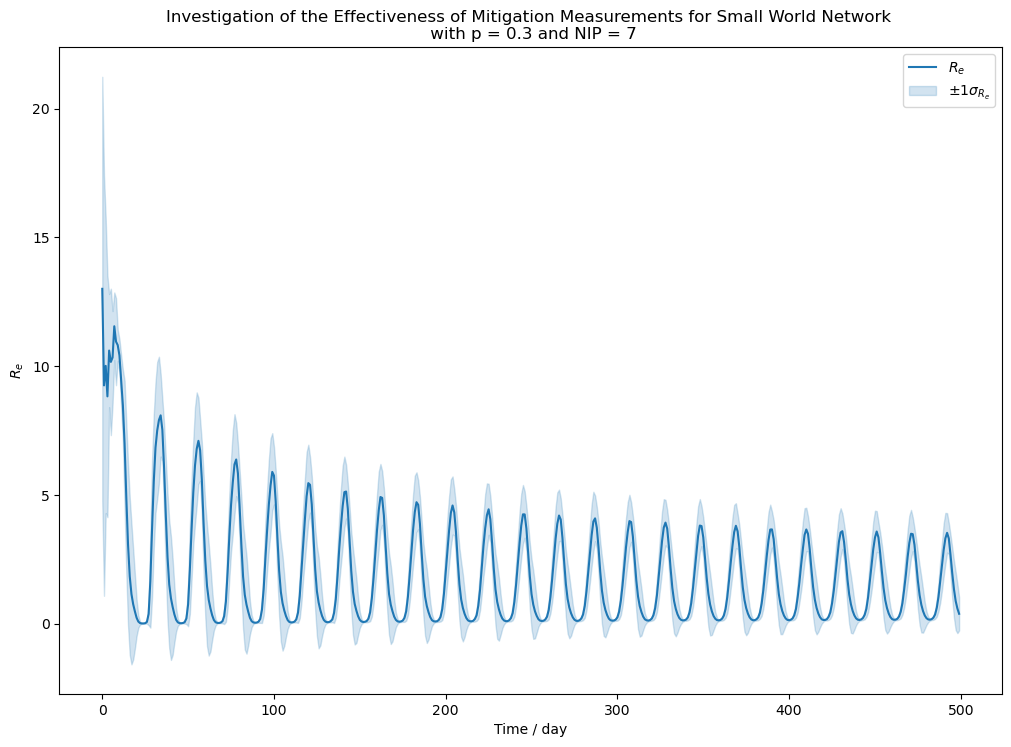

0.5 7  Repeat Number:  0


100%|█████████████████████████████████████████| 500/500 [01:23<00:00,  6.00it/s]


0.5 7  Repeat Number:  1


100%|█████████████████████████████████████████| 500/500 [01:23<00:00,  5.98it/s]


0.5 7  Repeat Number:  2


  5%|██▏                                       | 26/500 [00:03<01:06,  7.17it/s]


0.5 7  Repeat Number:  3


100%|█████████████████████████████████████████| 500/500 [01:24<00:00,  5.91it/s]


0.5 7  Repeat Number:  4


100%|█████████████████████████████████████████| 500/500 [01:24<00:00,  5.95it/s]


0.5 7  Repeat Number:  5


  5%|██                                        | 25/500 [00:03<01:03,  7.43it/s]


0.5 7  Repeat Number:  6


 10%|████                                      | 48/500 [00:06<01:04,  6.98it/s]


0.5 7  Repeat Number:  7


100%|█████████████████████████████████████████| 500/500 [01:23<00:00,  6.02it/s]


0.5 7  Repeat Number:  8


  5%|██▏                                       | 26/500 [00:03<01:04,  7.36it/s]


0.5 7  Repeat Number:  9


  5%|██                                        | 25/500 [00:03<01:04,  7.34it/s]


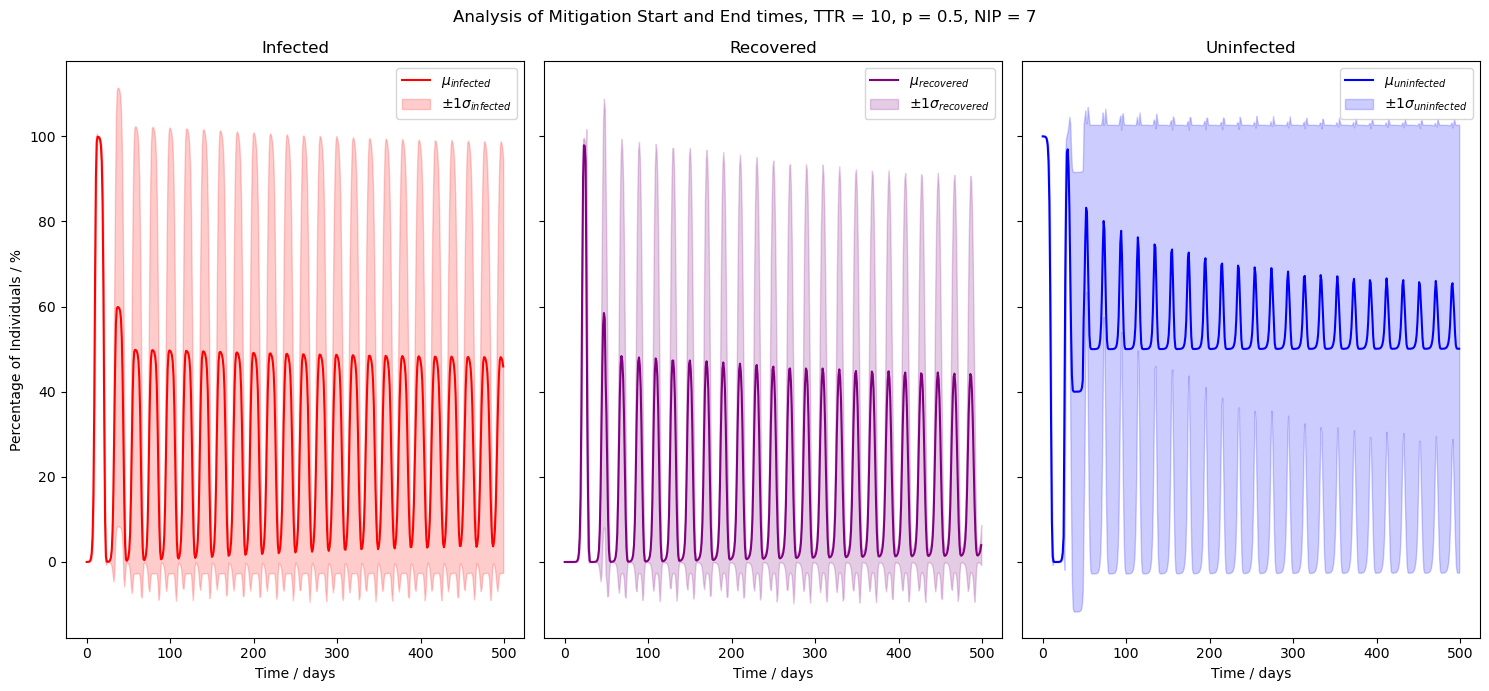

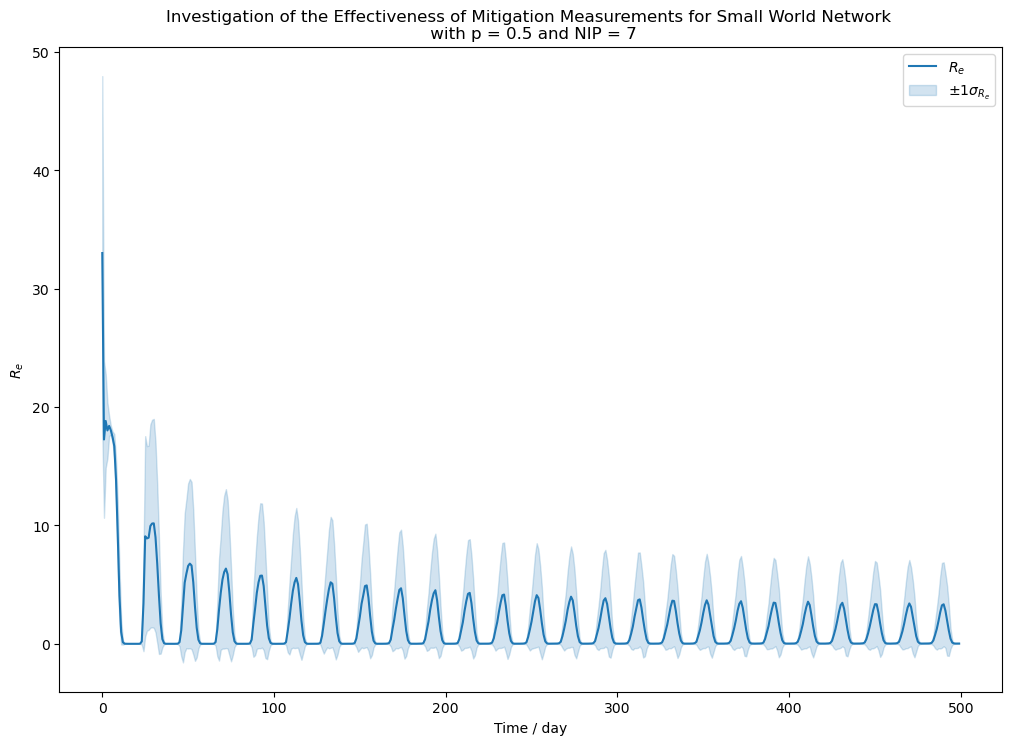

0.75 7  Repeat Number:  0


  4%|█▊                                        | 21/500 [00:03<01:09,  6.91it/s]


0.75 7  Repeat Number:  1


  4%|█▊                                        | 21/500 [00:03<01:14,  6.39it/s]


0.75 7  Repeat Number:  2


  4%|█▊                                        | 21/500 [00:03<01:09,  6.89it/s]


0.75 7  Repeat Number:  3


  4%|█▊                                        | 21/500 [00:03<01:09,  6.89it/s]


0.75 7  Repeat Number:  4


  4%|█▊                                        | 21/500 [00:03<01:09,  6.91it/s]


0.75 7  Repeat Number:  5


  4%|█▋                                        | 20/500 [00:02<01:10,  6.77it/s]


0.75 7  Repeat Number:  6


  4%|█▊                                        | 21/500 [00:03<01:09,  6.88it/s]


0.75 7  Repeat Number:  7


  4%|█▊                                        | 21/500 [00:03<01:08,  6.94it/s]


0.75 7  Repeat Number:  8


  4%|█▊                                        | 21/500 [00:03<01:10,  6.82it/s]


0.75 7  Repeat Number:  9


  4%|█▊                                        | 22/500 [00:03<01:07,  7.03it/s]


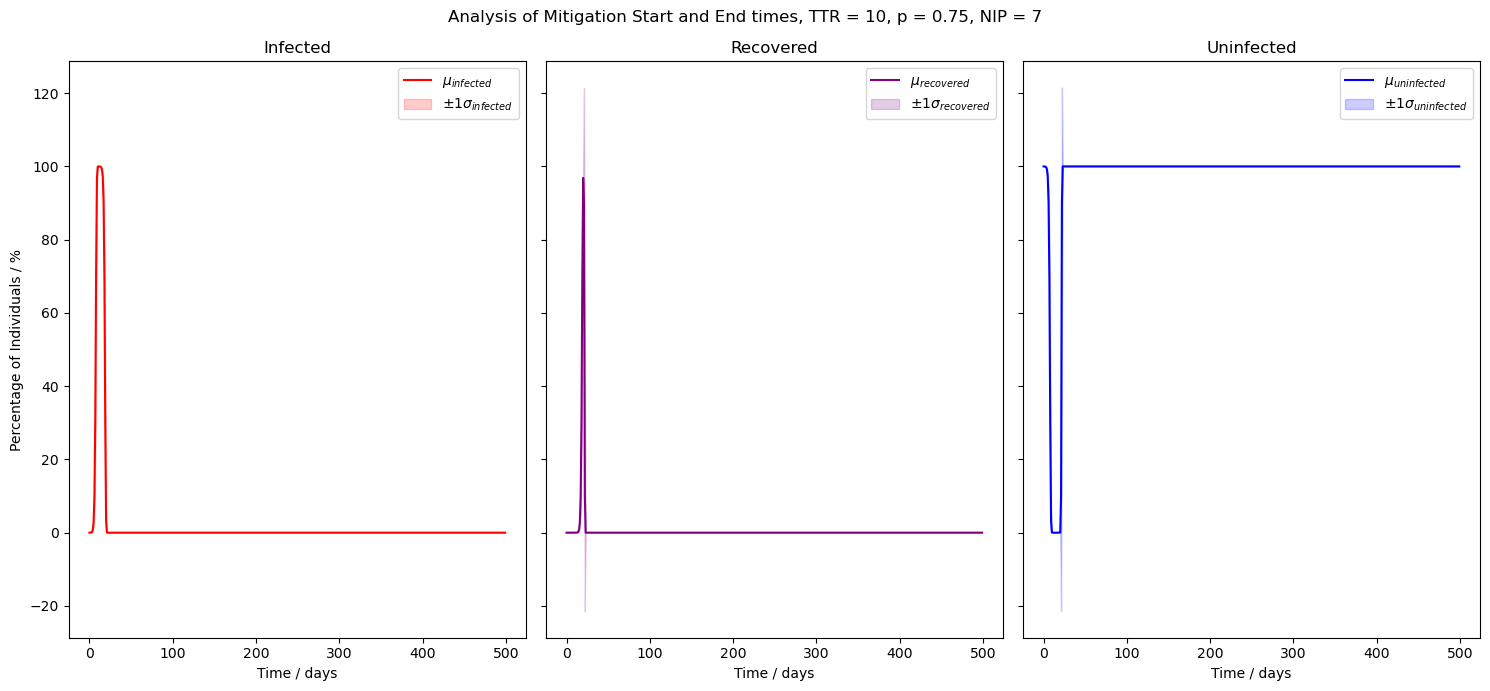

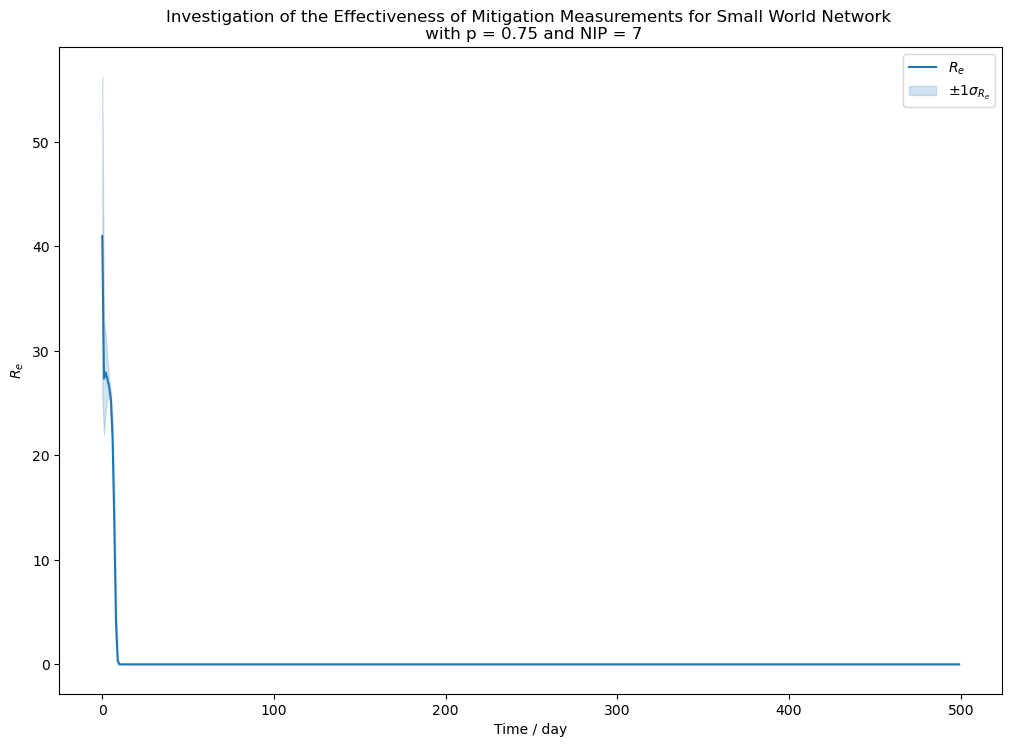

In [169]:
# Testing the class
repeats = 10 
num_nodes = 35000
num_sick = 1
avg_connection = 6
randomness = 0.4
TTR_val = 10
NIP = [7]
RP = 0.5
p = [0.02, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.75]
mitprop = 0.3
miteffective = 0.25
starttime = 0
endtime = 0
mitigation = [0, 0, 0, 0]
RP = 0.5
ntype = ['Small World']
numsteps = 500

meaninf_swharm_df = pd.DataFrame(columns=list(range(numsteps)))
stdinf_swharm_df = pd.DataFrame(columns=list(range(numsteps)))
meanrec_swharm_df = pd.DataFrame(columns=list(range(numsteps)))
stdrec_swharm_df = pd.DataFrame(columns=list(range(numsteps)))
meanuninf_swharm_df = pd.DataFrame(columns=list(range(numsteps)))
stduninf_swharm_df = pd.DataFrame(columns=list(range(numsteps)))
meanRT_swharm_df = pd.DataFrame(columns=list(range(numsteps)))
stdRT_swharm_df = pd.DataFrame(columns=list(range(numsteps)))

for nettype in ntype:
    for pval in p:
        for j in NIP:
            data_inf = []
            data_rec = []
            data_tot = []
            data_cum = []
            data_Re = []

            for rep in range(repeats):
                print(pval,j,' Repeat Number: ', rep)
                G_data = Pandemic_Network(network_type = nettype, nodes = num_nodes, pandemicprob = pval, mitigation_info = mitigation, NIP = j, RP = RP, sicknode = 1, SW_connections = avg_connection, SF_k = avg_connection/2, SW_randomness = randomness, plots = False, TTR = TTR_val).propagate(steps = numsteps)
                # timestamps.append(G_data[0])
                data_inf.append(G_data[1])
                data_rec.append(G_data[2])
                data_tot.append(G_data[3])
                data_cum.append(G_data[4])
                data_Re.append(G_data[5])

            data_inf_std = []
            data_inf_mean = []

            data_rec_std = []
            data_rec_mean = []

            data_tot_std = []
            data_tot_mean = []

            data_Re_std = []
            data_Re_mean = []

            for i in range(numsteps):
                data_inf_std.append(statistics.stdev([data_inf[j][i] if i < len(data_inf[j]) else 0 for j in range(repeats)]))
                data_inf_mean.append(statistics.mean([data_inf[j][i] if i < len(data_inf[j]) else 0 for j in range(repeats)]))

                data_rec_std.append(statistics.stdev([data_rec[j][i] if i < len(data_inf[j]) else 0 for j in range(repeats)]))
                data_rec_mean.append(statistics.mean([data_rec[j][i] if i < len(data_inf[j]) else 0 for j in range(repeats)]))

                data_tot_std.append(statistics.stdev([data_tot[j][i] if i < len(data_inf[j]) else num_nodes for j in range(repeats)]))
                data_tot_mean.append(statistics.mean([data_tot[j][i] if i < len(data_inf[j]) else num_nodes for j in range(repeats)]))

                data_Re_std.append(statistics.stdev([data_Re[j][i] if i < len(data_inf[j]) else 0 for j in range(repeats)]))
                data_Re_mean.append(statistics.mean([data_Re[j][i] if i < len(data_inf[j]) else 0 for j in range(repeats)]))

            meaninf_swharm_df.loc[len(meaninf_swharm_df)] = data_inf_mean
            stdinf_swharm_df.loc[len(stdinf_swharm_df)] = data_inf_std

            meanrec_swharm_df.loc[len(meanrec_swharm_df)] = data_rec_mean
            stdrec_swharm_df.loc[len(stdrec_swharm_df)] = data_rec_std

            meanuninf_swharm_df.loc[len(meanuninf_swharm_df)] = data_tot_mean
            stduninf_swharm_df.loc[len(stduninf_swharm_df)] = data_tot_std
            
            meanRT_swharm_df.loc[len(meanRT_swharm_df)] = data_Re_mean
            stdRT_swharm_df.loc[len(stdRT_swharm_df)] = data_Re_std

            data_inf_low = np.array([data_inf_mean[i] - data_inf_std[i] for i in range(len(data_inf_std))])
            data_inf_high = np.array([data_inf_mean[i] + data_inf_std[i] for i in range(len(data_inf_std))])

            data_rec_low = np.array([data_rec_mean[i] - data_rec_std[i] for i in range(len(data_rec_std))])
            data_rec_high = np.array([data_rec_mean[i] + data_rec_std[i] for i in range(len(data_rec_std))])

            data_tot_low = np.array([data_tot_mean[i] - data_tot_std[i] for i in range(len(data_tot_std))])
            data_tot_high = np.array([data_tot_mean[i] + data_tot_std[i] for i in range(len(data_tot_std))])
            
            data_Re_low = np.array([data_Re_mean[i] - data_Re_std[i] for i in range(len(data_Re_std))])
            data_Re_high = np.array([data_Re_mean[i] + data_Re_std[i] for i in range(len(data_Re_std))])

            timestamps = [i for i in range(len(data_inf_mean))]

            fig, ax = plt.subplots(nrows = 1, ncols = 3, sharey = True, sharex = True, figsize = (15,7))

            ax[0].plot(timestamps,np.array(data_inf_mean)/num_nodes*100, color = 'red', label = '$\mu_{infected}$')
            ax[1].plot(timestamps,np.array(data_rec_mean)/num_nodes*100, color = 'purple', label = '$\mu_{recovered}$')
            ax[2].plot(timestamps,np.array(data_tot_mean)/num_nodes*100, color = 'blue', label = '$\mu_{uninfected}$')

            ax[0].fill_between(timestamps, data_inf_low/num_nodes*100, data_inf_high/num_nodes*100, alpha = 0.2, color = 'red', label = '$ \pm 1\sigma_{infected}$')
            ax[1].fill_between(timestamps, data_rec_low/num_nodes*100, data_rec_high/num_nodes*100, alpha = 0.2, color = 'purple', label = '$ \pm 1\sigma_{recovered}$')
            ax[2].fill_between(timestamps, data_tot_low/num_nodes*100, data_tot_high/num_nodes*100, alpha = 0.2, color = 'blue', label = '$ \pm 1\sigma_{uninfected}$')

            fig.suptitle('Analysis of Mitigation Start and End times, TTR = {}, p = {}, NIP = {}'.format(TTR_val, pval, j))
            ax[0].set_title('Infected')
            ax[1].set_title('Recovered')
            ax[2].set_title('Uninfected')

            ax[0].set_ylabel('Percentage of Individuals / %')
            ax[0].set_xlabel('Time / days')
            ax[1].set_xlabel('Time / days')
            ax[2].set_xlabel('Time / days')

            ax[0].legend()
            ax[1].legend()
            ax[2].legend()
            plt.tight_layout()
            plt.show()
            
            plt.figure(figsize = (10,7))
            plt.plot(timestamps, data_Re_mean, color = 'tab:blue', label = r'$R_e$')
            plt.fill_between(timestamps, data_Re_low, data_Re_high, alpha = 0.2, color = 'tab:blue', label = '$ \pm 1\sigma_{R_e}$')
            plt.legend()
            plt.tight_layout()
            plt.xlabel('Time / day')
            plt.ylabel(r'$R_e$')
            plt.title('Investigation of the Effectiveness of Mitigation Measurements for {} Network \n with p = {} and NIP = {}'.format(nettype, pval, j))
            plt.show()

In [170]:
# Saving dataframes
# NIP = [1, 3, 5, 7, 10, 12, 15, 20, 50]
# p = 0.02, 0.05
meaninf_swharm_df.to_csv('SW_MeanInfected_pdata')
stdinf_swharm_df.to_csv('SW_errorInfected_pdata')
meanrec_swharm_df.to_csv('SW_MeanRecovered_pdata')
stdrec_swharm_df.to_csv('SW_errorRecovered_pdata')
meanuninf_swharm_df.to_csv('SW_MeanNoninfected_pdata')
stduninf_swharm_df.to_csv('SW_errorNoninfected_pdata')
meanRT_swharm_df.to_csv('SW_MeanRe_pdata')
stdRT_swharm_df.to_csv('SW_errorRe_pdata')


## Finding the pattern between Changing NIP and Harmonic Oscillations

Underdamped harmonic equation got from: https://phys.libretexts.org/Bookshelves/University_Physics/University_Physics_(OpenStax)/Book%3A_University_Physics_I_-_Mechanics_Sound_Oscillations_and_Waves_(OpenStax)/15%3A_Oscillations/15.06%3A_Damped_Oscillations

### Scale Free

0     24
1     21
2     21
3     21
4     22
5     10
6     10
7    167
8     10
9     10
dtype: int64


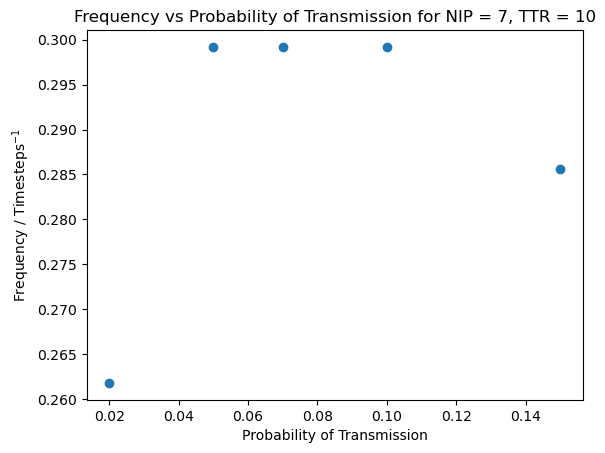

4
[-39.079142857142855, -0.2617993877991494, 4.71238898038469, 0.1, 39.105714285714285]
[-50.91435625   0.14794802   5.5623524    0.07230235  38.82240341]


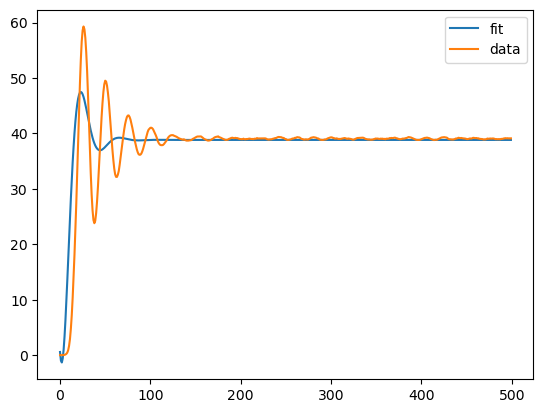

2
[-52.11485714285713, -0.2991993003418851, 4.71238898038469, 0.2, 52.15171428571428]
[-5.99000514e+01 -2.97865215e-01  6.81561320e+00  1.19794693e-02
  5.28226102e+01]


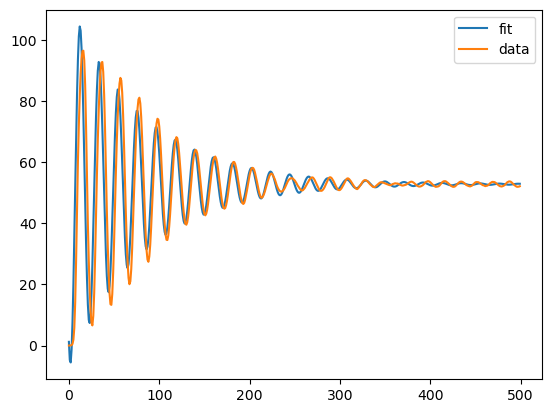

2
[-55.42485714285714, -0.2991993003418851, 4.71238898038469, 0.25, 55.484857142857145]
[-5.98113072e+01 -3.11481535e-01  6.74082464e+00  7.15032068e-03
  5.49749973e+01]


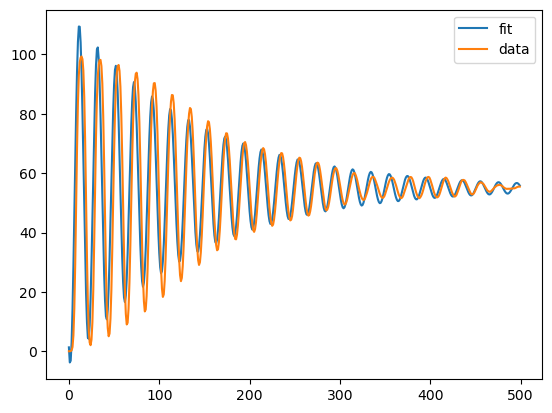

2
[-62.22942857142858, -0.2991993003418851, 4.71238898038469, 0.3333333333333333, 62.272000000000006]
[-5.66951608e+01 -3.22059601e-01  6.83657187e+00  3.15504798e-03
  5.38859216e+01]


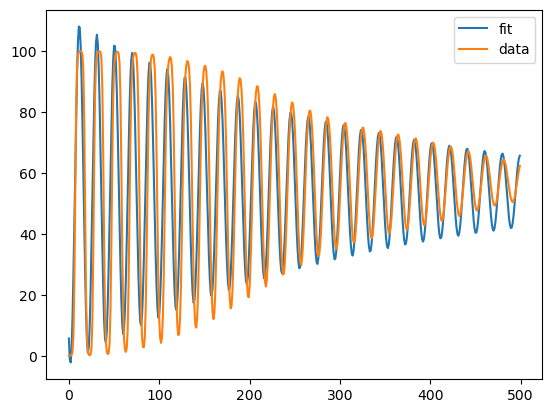

2
[-25.27114285714286, -0.28559933214452665, 4.71238898038469, 1.0, 25.357428571428574]
[-1.15601283e+02 -2.03352268e-01  4.99639277e+00  4.44508570e-02
  2.30893358e+01]


/var/folders/_z/js6kczb16373q18ffxtmcvxm0000gn/T/ipykernel_46113/2190013619.py:5: RuntimeWarning: overflow encountered in exp
  return A*np.exp((-decay*x))*np.cos(w*x+phase)+ equilbrium
/var/folders/_z/js6kczb16373q18ffxtmcvxm0000gn/T/ipykernel_46113/2190013619.py:5: RuntimeWarning: overflow encountered in multiply
  return A*np.exp((-decay*x))*np.cos(w*x+phase)+ equilbrium


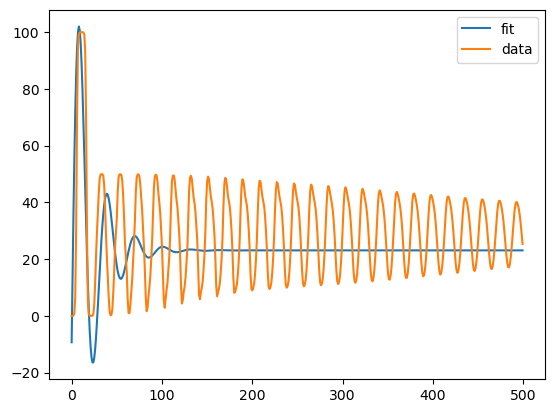

2
[0.10542857142857143, -0.6283185307179586, 4.71238898038469, 0.06666666666666667, 0.0]
[ 0.10542857 -0.62831853  4.71238898  0.06666667  0.        ]


/Users/alexcoleman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma


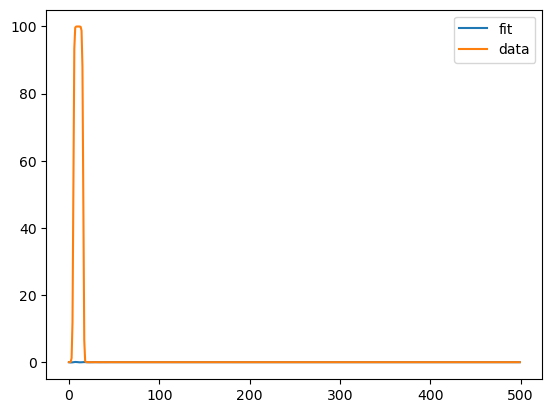

1
[0.01742857142857143, -0.6283185307179586, 4.71238898038469, 0.05555555555555555, 0.0]
[ 0.01742857 -0.62831853  4.71238898  0.05555556  0.        ]


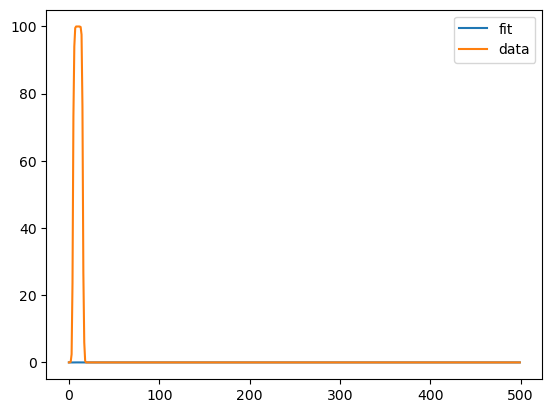

1
[0.026, -0.03762386411484782, 4.71238898038469, 0.0625, 0.0]
[ 0.026      -0.03762386  4.71238898  0.0625      0.        ]


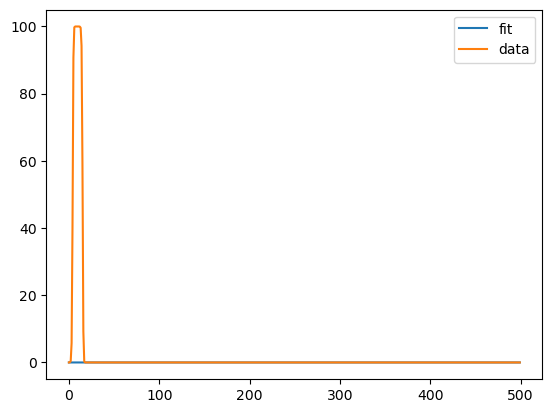

1
[0.072, -0.6283185307179586, 4.71238898038469, 0.07142857142857142, 0.0]
[ 0.072      -0.62831853  4.71238898  0.07142857  0.        ]


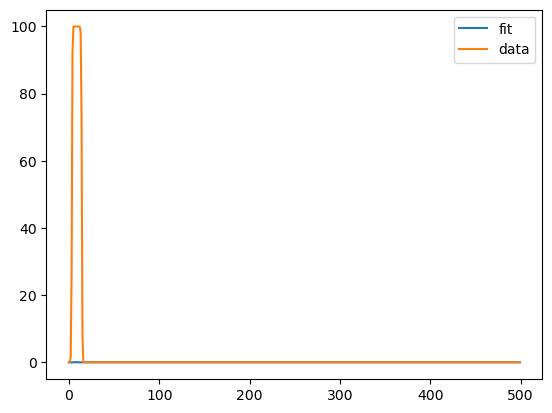

1
[0.05428571428571429, -0.6283185307179586, 4.71238898038469, 0.07142857142857142, 0.0]
[ 0.05428571 -0.62831853  4.71238898  0.07142857  0.        ]


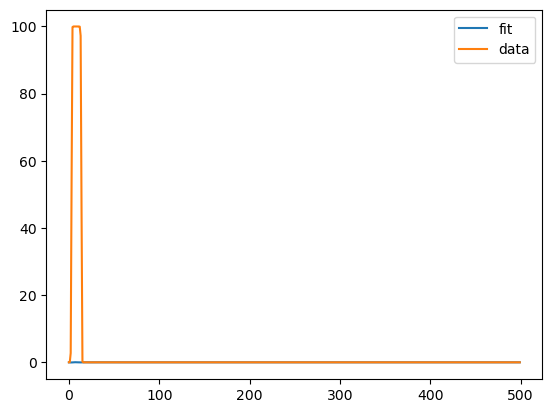

ValueError: x and y must be the same size

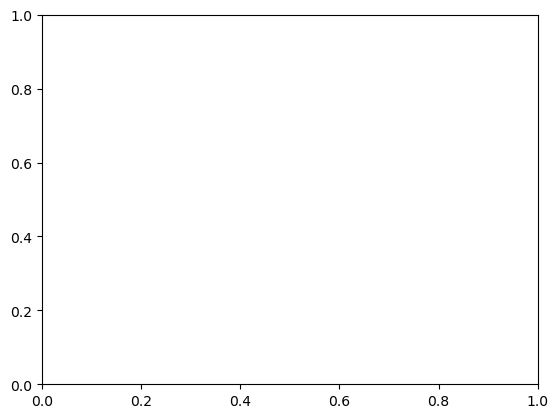

In [159]:
# decay = b/2m
from scipy.optimize import curve_fit

def underdamped(x, A, w, phase, decay, equilbrium):
    return A*np.exp((-decay*x))*np.cos(w*x+phase)+ equilbrium

#display(meaninf_sfharm_df)

# Fitting underdamped equation to mean infected 
# First 0-8 rows are for p = 0.02, rows 9-17 through p = 0.05

meaninfected = (meaninf_sfharm_df/num_nodes)*100
stdinfected = (stdinf_sfharm_df/num_nodes)*100

# To guess the period of oscillations
# Custom function to find the difference between the two largest values with a minimum separation
def diff_with_separation(row, separation=5):
    # Sort the row values while keeping track of original indices
    sorted_indices = list(np.argsort(row)[::-1])
    largest_value_index = sorted_indices[0]
    largest_value = row[largest_value_index]
    
    # Initialize variables to store the second largest value that meets the separation requirement
    second_largest_value = None
    second_largest_index = None
    
    # Iterate over the sorted indices to find the second largest value that meets the separation requirement
    for index in sorted_indices[1:]:
        if np.abs(index - largest_value_index) >= separation:
            second_largest_value = row[index]
            second_largest_index = index
            break
    
    # If a valid second largest value is found, calculate the difference
    if second_largest_value is not None:
        return np.abs(largest_value_index - second_largest_index)
    else:
        return 10  # Return NaN if no valid second value is found

period_guess = meaninfected.apply(diff_with_separation, axis=1, separation=10)
print(period_guess)

#Plotting guessed frequency against NIP
plt.scatter([0.02, 0.05, 0.07, 0.1, 0.15], 2*np.pi/period_guess[:-5])
plt.xlabel('Probability of Transmission')
plt.ylabel(r'Frequency / Timesteps$^{-1}$')
plt.title('Frequency vs Probability of Transmission for NIP = 7, TTR = 10')
plt.show()

decayfac = []

time = np.linspace(0, 499, 500)
for i in range(len(meaninfected)):
    meaninfecteddata = meaninfected.loc[i]
    stdinfecteddata = stdinfected.loc[i]
    
    offset = np.where(meaninfecteddata > 0.015)[0][0]
    print(offset)
    equilbriumguess = meaninfecteddata[499]
    init_amp = meaninfecteddata[offset] - equilbriumguess
    
    for j, value in enumerate(meaninfecteddata[offset:]):
        if np.abs(value-equilbriumguess) <= np.abs(init_amp / np.e) and j > offset:
            tauguess = j-offset
            break
            
        elif j == 499:
            tauguess = 499
            
    decayfac.append(1/tauguess)
    guess = [init_amp, -2*np.pi/period_guess[i], 3*np.pi/2, 1/tauguess, equilbriumguess]
    print(guess)
    fit_params, unc_params = curve_fit(underdamped, time[offset:]-offset, meaninfecteddata[offset:], guess, sigma = np.sqrt(stdinfecteddata[offset:]))
    print(fit_params)
    plt.plot(time, underdamped(time, *fit_params), label = 'fit')
    plt.plot(time, meaninfecteddata, label = 'data')
    plt.legend()
    plt.show()
    
    
plt.scatter([1, 3, 5, 7, 10, 12, 15, 20], decayfac[:-1])
plt.xlabel('NIP / Timesteps')
plt.ylabel(r'Decay Factor / Timesteps$^{-1}$')
plt.title('Decay factor vs NIP for p = 0.02, TTR = 10')
plt.show()
    

### Small World

0    61
1    35
2    29
3    26
4    24
5    24
6    23
7    23
8    23
9    10
dtype: int64


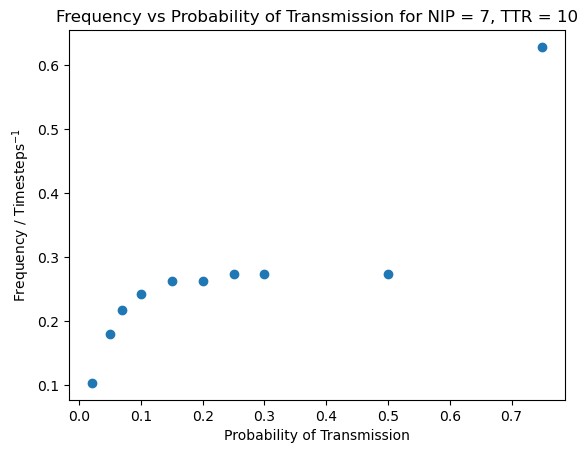

0      0.002857
1      0.003714
2      0.004000
3      0.004286
4      0.004857
         ...   
495    0.000000
496    0.000000
497    0.000000
498    0.000000
499    0.000000
Name: 0, Length: 500, dtype: float64
0       0.002857
1       0.004857
2       0.006000
3       0.007143
4       0.008000
         ...    
495    34.559143
496    34.559714
497    34.484857
498    34.502857
499    34.514571
Name: 1, Length: 500, dtype: float64
8
[-34.49857142857143, -0.17951958020513104, 4.71238898038469, 0.02564102564102564, 34.51457142857143]
[-6.36886928e+01 -2.62726228e-02  7.29364139e+00  2.86745869e-02
  3.45274094e+01]


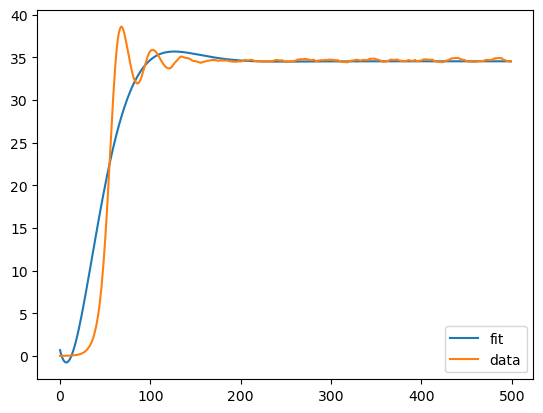

0       0.002857
1       0.003714
2       0.005714
3       0.007429
4       0.009714
         ...    
495    41.295429
496    41.259143
497    41.227143
498    41.263143
499    41.281143
Name: 2, Length: 500, dtype: float64
6
[-41.265142857142855, -0.21666156231653746, 4.71238898038469, 0.034482758620689655, 41.281142857142854]
[-6.95979708e+01  3.49946503e-02  5.33238713e+00  3.43281922e-02
  4.10439904e+01]


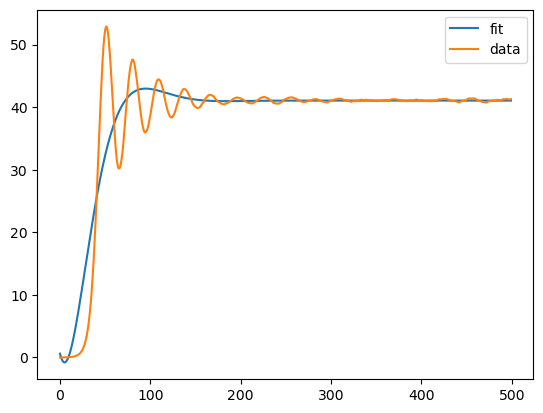

0       0.002857
1       0.004857
2       0.006000
3       0.008000
4       0.012000
         ...    
495    46.399429
496    46.360571
497    46.266857
498    46.251714
499    46.251143
Name: 3, Length: 500, dtype: float64
5
[-46.23571428571429, -0.241660973353061, 4.71238898038469, 0.05, 46.25114285714286]
[-8.06376158e+01  4.38530598e-02  5.31536527e+00  4.65986750e-02
  4.62542234e+01]


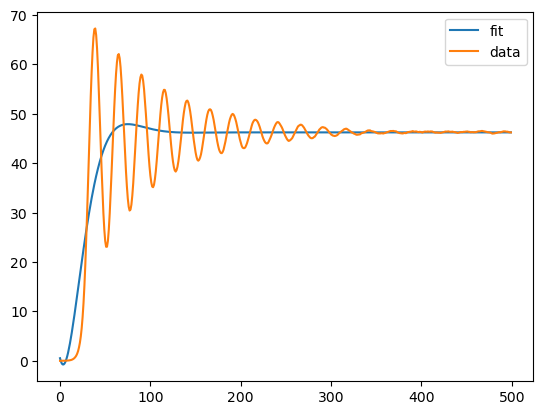

0       0.002857
1       0.004857
2       0.008857
3       0.017143
4       0.026571
         ...    
495    46.880000
496    47.128000
497    47.576000
498    48.306286
499    49.238000
Name: 4, Length: 500, dtype: float64
3
[-49.22085714285714, -0.2617993877991494, 4.71238898038469, 0.06666666666666667, 49.238]
[-2.96867001e+02  2.20115044e-02  4.88035786e+00  9.95682340e-02
  5.02403880e+01]


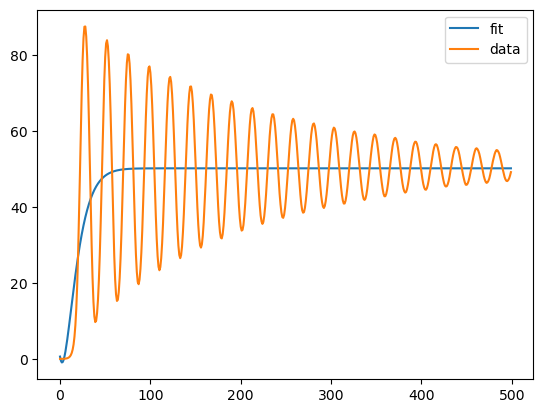

0       0.002857
1       0.006571
2       0.014571
3       0.028286
4       0.046571
         ...    
495    46.786571
496    51.890571
497    56.986286
498    61.717143
499    65.534857
Name: 5, Length: 500, dtype: float64
3
[-65.50657142857143, -0.2617993877991494, 4.71238898038469, 0.09090909090909091, 65.53485714285715]
[-6.00743255e+01  2.50217117e-01  5.55793702e+00  1.36449178e-02
  5.08940700e+01]


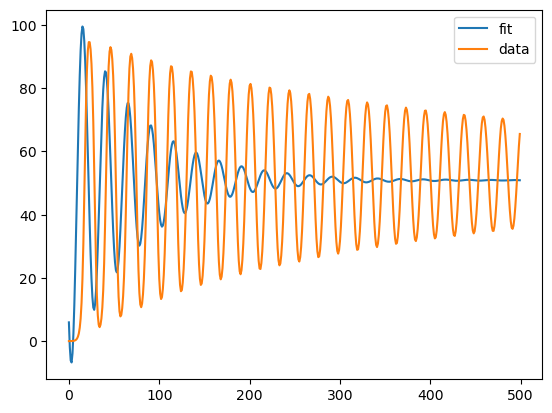

0       0.002857
1       0.007143
2       0.015143
3       0.031143
4       0.064857
         ...    
495    33.659714
496    27.668571
497    24.544000
498    24.113429
499    26.049429
Name: 6, Length: 500, dtype: float64
2
[-26.03428571428571, -0.2731819698773733, 4.71238898038469, 0.1111111111111111, 26.049428571428567]
[-6.23193846e+01  2.66063657e-01  5.62749636e+00  1.07779120e-02
  5.35309229e+01]


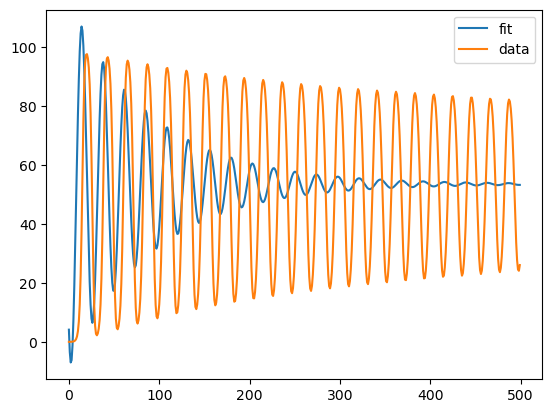

0       0.002857
1       0.006571
2       0.012571
3       0.026286
4       0.054000
         ...    
495    63.968286
496    73.692857
497    80.337714
498    84.093143
499    85.880286
Name: 7, Length: 500, dtype: float64
3
[-85.85399999999998, -0.2731819698773733, 4.71238898038469, 0.1111111111111111, 85.8802857142857]
[-6.45929332e+01  2.76955120e-01  5.64589673e+00  9.77692932e-03
  5.55166373e+01]


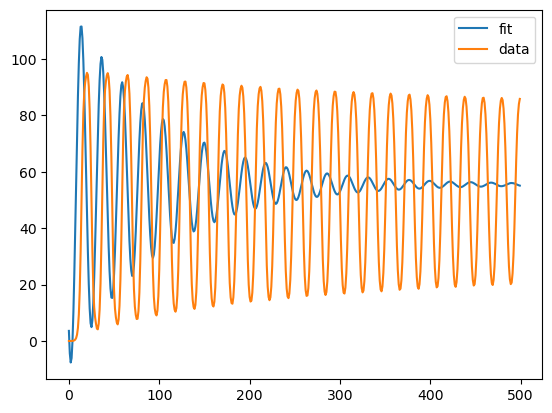

0       0.002857
1       0.012286
2       0.034286
3       0.097429
4       0.273429
         ...    
495    47.547143
496    48.120857
497    47.874286
498    47.214857
499    45.932857
Name: 8, Length: 500, dtype: float64
2
[-45.89857142857143, -0.2731819698773733, 4.71238898038469, 0.2, 45.932857142857145]
[-5.47096920e+01  3.07948581e-01  5.41192902e+00  2.37184013e-03
  4.02363703e+01]


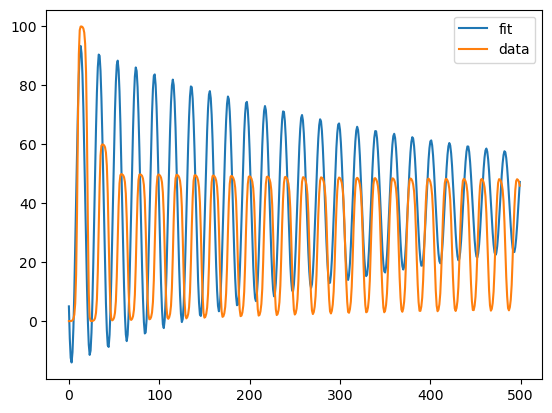

0      0.002857
1      0.014571
2      0.055714
3      0.210857
4      0.780571
         ...   
495    0.000000
496    0.000000
497    0.000000
498    0.000000
499    0.000000
Name: 9, Length: 500, dtype: float64
2
[0.055714285714285716, -0.6283185307179586, 4.71238898038469, 0.05555555555555555, 0.0]
[ 0.05571429 -0.62831853  4.71238898  0.05555556  0.        ]


/Users/alexcoleman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma


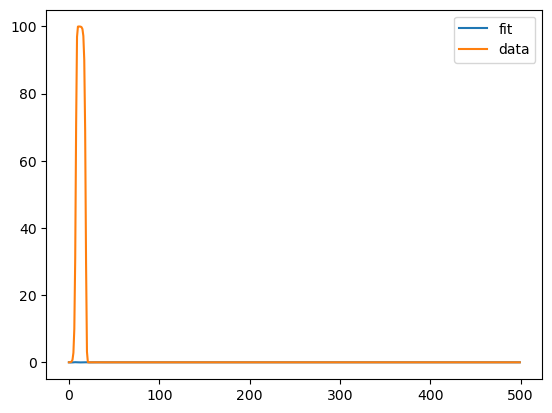

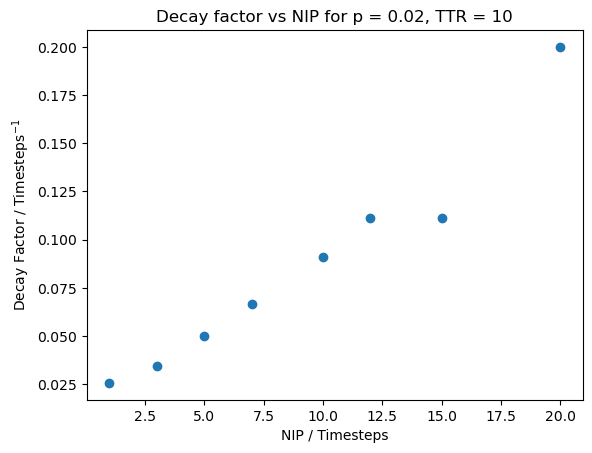

In [176]:
# decay = b/2m
from scipy.optimize import curve_fit


def underdamped(x, A, w, phase, decay, equilbrium):
    return A*np.exp((-decay*x))*np.cos(w*x+phase)+ equilbrium

#display(meaninf_swharm_df)

# Fitting underdamped equation to mean infected 
# First 0-8 rows are for p = 0.02, rows 9-17 through p = 0.05

meaninfected = (meaninf_swharm_df/num_nodes)*100
stdinfected = (stdinf_swharm_df/num_nodes)*100

# To guess the period of oscillations
# Custom function to find the difference between the two largest values with a minimum separation
def diff_with_separation(row, separation=5):
    # Sort the row values while keeping track of original indices
    sorted_indices = list(np.argsort(row)[::-1])
    largest_value_index = sorted_indices[0]
    largest_value = row[largest_value_index]
    
    # Initialize variables to store the second largest value that meets the separation requirement
    second_largest_value = None
    second_largest_index = None
    
    # Iterate over the sorted indices to find the second largest value that meets the separation requirement
    for index in sorted_indices[1:]:
        if np.abs(index - largest_value_index) >= separation:
            second_largest_value = row[index]
            second_largest_index = index
            break
    
    # If a valid second largest value is found, calculate the difference
    if second_largest_value is not None:
        return np.abs(largest_value_index - second_largest_index)
    else:
        return 10  # Return NaN if no valid second value is found

period_guess = meaninfected.apply(diff_with_separation, axis=1, separation=10)
print(period_guess)

#Plotting guessed frequency against NIP
plt.scatter([0.02, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.75], 2*np.pi/period_guess)
plt.xlabel('Probability of Transmission')
plt.ylabel(r'Frequency / Timesteps$^{-1}$')
plt.title('Frequency vs Probability of Transmission for NIP = 7, TTR = 10')
plt.show()

decayfac = []

time = np.linspace(0, 499, 500)
for i in range(len(meaninfected)):
    meaninfecteddata = meaninfected.loc[i]
    print(meaninfecteddata)
    stdinfecteddata = stdinfected.loc[i]
    
    offset = np.where(meaninfecteddata > 0.015)[0]
    if len(offset) == 0:
        continue
    else:
        offset = offset[0]
    print(offset)
    equilbriumguess = meaninfecteddata[499]
    init_amp = meaninfecteddata[offset] - equilbriumguess
    
    for j, value in enumerate(meaninfecteddata[offset:]):
        if np.abs(value-equilbriumguess) <= np.abs(init_amp / np.e) and j > offset:
            tauguess = j-offset
            break
            
        elif j == 499:
            tauguess = 499
            
    decayfac.append(1/tauguess)
    guess = [init_amp, -2*np.pi/period_guess[i], 3*np.pi/2, 1/tauguess, equilbriumguess]
    print(guess)
    fit_params, unc_params = curve_fit(underdamped, time[offset:]-offset, meaninfecteddata[offset:], guess, sigma = np.sqrt(stdinfecteddata[offset:]))
    print(fit_params)
    plt.plot(time, underdamped(time, *fit_params), label = 'fit')
    plt.plot(time, meaninfecteddata, label = 'data')
    plt.legend()
    plt.show()
    
    
plt.scatter([1, 3, 5, 7, 10, 12, 15, 20], decayfac[:-1])
plt.xlabel('NIP / Timesteps')
plt.ylabel(r'Decay Factor / Timesteps$^{-1}$')
plt.title('Decay factor vs NIP for p = 0.02, TTR = 10')
plt.show()
    